In [1]:
from drug_gan.trials.drug_gan import (load_dataset, 
                    normalize_dataframe, 
                    build_individual_map, 
                    IndividualSequenceDataset, 
                    Generator, 
                    Discriminator, 
                    DATA_SOURCE,
                    MODEL_SAVE_PATH,
                    DEVICE, 
                    NOISE_DIM, 
                    GEN_HIDDEN_DIM, 
                    DISC_HIDDEN_DIM)

Using device: cpu


In [2]:
orig_df = load_dataset(DATA_SOURCE)
orig_df.head()


,ID,TIME,EF,AGE,A1,A2,A3,AL1,AL2,AL3,KEO,EO,EM,EC50,N,E,PRED,RES,WRES
0,1,0.0,18.85,30.58,0.097699,0.006491,0.00013,0.43415,0.057008,0.009551,0.56119,20.508,4.7678,9.0496,2.5286,20.508,19.975,-1.125300,-0.73137
1,1,0.5,19.91,30.58,0.097699,0.006491,0.00013,0.43415,0.057008,0.009551,0.56119,20.508,4.7678,9.0496,2.5286,20.500,19.971,-0.061008,-0.15100
2,1,1.0,19.51,30.58,0.097699,0.006491,0.00013,0.43415,0.057008,0.009551,0.56119,20.508,4.7678,9.0496,2.5286,20.332,19.893,-0.382520,-0.25709
3,1,1.5,18.67,30.58,0.097699,0.006491,0.00013,0.43415,0.057008,0.009551,0.56119,20.508,4.7678,9.0496,2.5286,19.620,19.585,-0.914520,-0.32364
4,1,2.0,19.03,30.58,0.097699,0.006491,0.00013,0.43415,0.057008,0.009551,0.56119,20.508,4.7678,9.0496,2.5286,18.150,18.949,0.080875,0.59570


In [3]:
df, stats = normalize_dataframe(orig_df.copy())
indiv_map = build_individual_map(df)
dataset = IndividualSequenceDataset(indiv_map)

G = Generator(NOISE_DIM, GEN_HIDDEN_DIM, dataset.max_length,
                dataset.feature_dim, dataset.feature_columns).to(DEVICE)
D = Discriminator(dataset.max_length, dataset.feature_dim, DISC_HIDDEN_DIM).to(DEVICE)

In [4]:
import torch
checkpoint = torch.load(MODEL_SAVE_PATH, map_location=DEVICE)
g_losses = checkpoint["g_losses"]
d_losses = checkpoint["d_losses"]

In [5]:


G.load_state_dict(checkpoint["G"])
D.load_state_dict(checkpoint["D"])
G.eval();

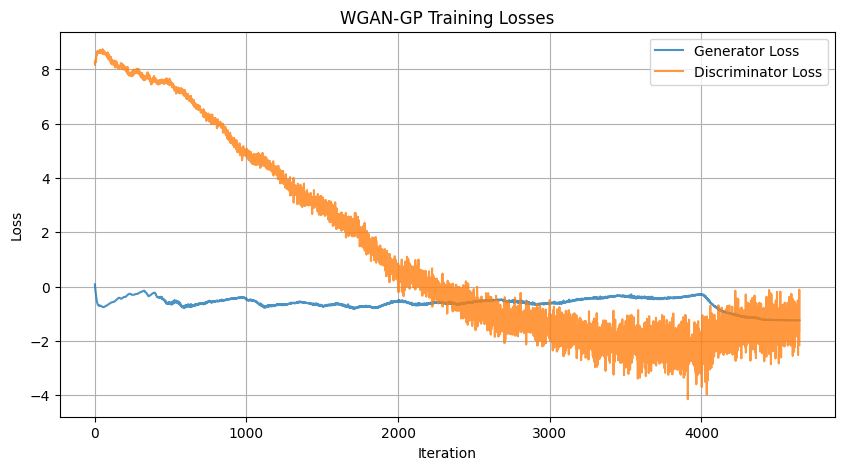

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Generator Loss", alpha=0.8)
plt.plot(d_losses, label="Discriminator Loss", alpha=0.8)
plt.title("WGAN-GP Training Losses")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

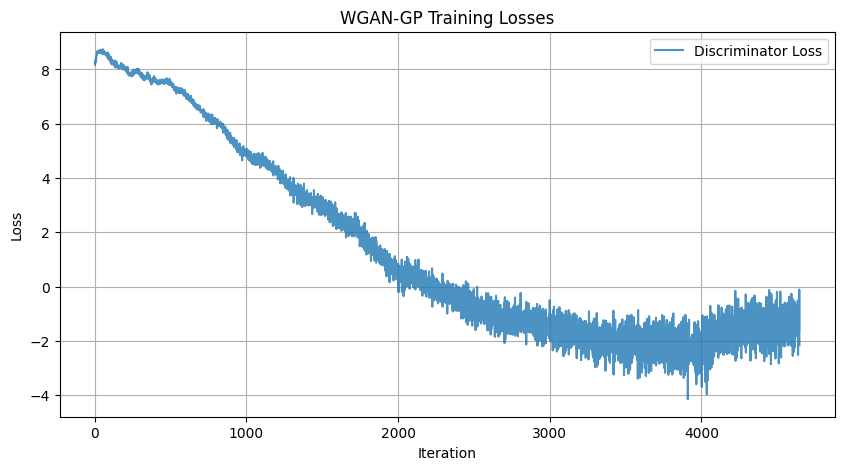

In [7]:

plt.figure(figsize=(10, 5))
plt.plot(d_losses, label="Discriminator Loss", alpha=0.8)
plt.title("WGAN-GP Training Losses")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
import pandas as pd
G.to(DEVICE)

num_new_individuals = 2000
show_num_individuals = 5
z = torch.randn(num_new_individuals, NOISE_DIM, device=DEVICE)
with torch.no_grad():
    fake_data = G(z).cpu()

# Convert to Pandas and display top rows per individual
all_rows = []
for i in range(num_new_individuals):
    fake_df = pd.DataFrame(fake_data[i].numpy(), columns=dataset.feature_columns)
    fake_df.insert(0, "ID", i + 1000)  # assign new synthetic IDs
    all_rows.append(fake_df)

synthetic_df = pd.concat(all_rows, ignore_index=True)


In [9]:
import pickle
from pathlib import Path

In [10]:
stats_path = Path(MODEL_SAVE_PATH).with_suffix(".stats.pkl")
if stats_path.exists():
    with open(stats_path, "rb") as f:
        stats = pickle.load(f)
    print(f"Loaded normalization stats from {stats_path}")
else:
    print("⚠️ No stats file found — cannot denormalize properly.")
    stats = None

Loaded normalization stats from /Users/srikanthchandar/Downloads/drug_gan_for_sri/models/trained_wgan_gp.stats.pkl


In [11]:
if stats:
    for c, (mean, std) in stats.items():
        if c in synthetic_df.columns:
            synthetic_df[c] = synthetic_df[c] * std + mean

In [12]:
print("\nGenerated Data - Top 5 Rows for Each Individual")
print("=" * 80)
for i in range(show_num_individuals):
    sub = synthetic_df[synthetic_df["ID"] == 1000 + i].head(5)
    print(f"\nIndividual ID: {1000 + i} (Total rows: {dataset.max_length})")
    print("=" * 80)
    print(sub.to_string(index=False))


Generated Data - Top 5 Rows for Each Individual

Individual ID: 1000 (Total rows: 145)
  ID  TIME        EF       AGE       A1       A2      A3      AL1      AL2     AL3      KEO       EO       EM      EC50        N         E      PRED       RES      WRES
1000   0.0 19.705212 39.619171 0.116478 0.014174 0.00084 1.088756 0.118052 0.02485 0.983107 17.80703 4.225758 17.436619 4.117254 19.440357 18.605236 -3.124667 -1.012984
1000   0.5 19.705212 39.619171 0.116478 0.014174 0.00084 1.088756 0.118052 0.02485 0.983107 17.80703 4.225758 17.436619 4.117254 19.440357 18.605236  3.989578  1.059150
1000   1.0 19.705212 39.619171 0.116478 0.014174 0.00084 1.088756 0.118052 0.02485 0.983107 17.80703 4.225758 17.436619 4.117254  7.197032 18.605225 -3.124621  1.059365
1000   1.5 19.705069 39.619171 0.116478 0.014174 0.00084 1.088756 0.118052 0.02485 0.983107 17.80703 4.225758 17.436619 4.117254  7.202339  7.152572  3.989707  1.059354
1000   2.0 19.704952 39.619171 0.116478 0.014174 0.00084 1.088756 0

In [13]:
# Descriptive statistics for the entire real dataset
print("=" * 80)
print("DESCRIPTIVE STATISTICS - ENTIRE DATASET")
print("=" * 80)
print(f"\nTotal number of rows: {len(orig_df)}")
print(f"Number of individuals: {orig_df['ID'].nunique()}")
print(f"Average rows per individual: {len(orig_df) / orig_df['ID'].nunique():.2f}")
print("\nColumn ranges and statistics:")
print("=" * 80)

# Show descriptive statistics for all columns
desc_stats = orig_df.describe()
display(desc_stats)

# Show min and max for each column
print("\n" + "=" * 80)
print("MINIMUM AND MAXIMUM VALUES FOR EACH COLUMN:")
print("=" * 80)
for col in orig_df.columns:
    if col != 'ID':
        print(f"{col:15s}: Min = {orig_df[col].min():12.6f}, Max = {orig_df[col].max():12.6f}, Range = {orig_df[col].max() - orig_df[col].min():12.6f}")

DESCRIPTIVE STATISTICS - ENTIRE DATASET

Total number of rows: 3989
Number of individuals: 61
Average rows per individual: 65.39

Column ranges and statistics:


,ID,TIME,EF,AGE,A1,A2,A3,AL1,AL2,AL3,KEO,EO,EM,EC50,N,E,PRED,RES,WRES
count,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000
mean,37.112810,21.131988,13.311306,54.856789,0.180676,0.020621,0.000293,0.843570,0.100683,0.012018,0.536137,20.572091,5.883951,11.624163,2.842091,13.318496,12.878895,0.432412,0.023103
std,17.081383,15.010643,6.393905,20.176750,0.064214,0.006447,0.000546,0.245232,0.017371,0.012834,0.447095,2.765079,1.658227,5.812874,1.725208,6.121860,5.726342,3.557303,1.036262
min,1.000000,0.000000,1.410000,20.000000,0.059153,0.006491,0.000030,0.430110,0.057008,0.002506,0.140010,13.860000,2.945600,3.477300,1.188600,3.339400,5.519400,-18.295000,-6.350600
25%,25.000000,9.000000,7.421300,33.000000,0.128060,0.015598,0.000053,0.656520,0.090920,0.004194,0.306990,18.837000,4.680400,7.779600,1.750000,7.452000,6.655300,-1.571400,-0.464530
50%,40.000000,19.000000,12.673000,59.000000,0.172520,0.019768,0.000079,0.819010,0.098791,0.006141,0.442810,20.469000,5.580900,9.709100,2.226700,12.856000,12.924000,0.291280,0.007131
75%,52.000000,31.000000,19.097000,72.000000,0.234980,0.024185,0.000157,1.025300,0.111620,0.012469,0.652120,22.018000,7.012500,15.117000,3.376200,19.222000,19.157000,2.482900,0.532960
max,61.000000,100.000000,28.840000,85.000000,0.314380,0.041004,0.003435,1.459600,0.155810,0.056608,4.398200,26.922000,11.447000,28.013000,10.240000,26.922000,19.975000,18.821000,6.425500



MINIMUM AND MAXIMUM VALUES FOR EACH COLUMN:
TIME           : Min =     0.000000, Max =   100.000000, Range =   100.000000
EF             : Min =     1.410000, Max =    28.840000, Range =    27.430000
AGE            : Min =    20.000000, Max =    85.000000, Range =    65.000000
A1             : Min =     0.059153, Max =     0.314380, Range =     0.255227
A2             : Min =     0.006491, Max =     0.041004, Range =     0.034513
A3             : Min =     0.000030, Max =     0.003435, Range =     0.003404
AL1            : Min =     0.430110, Max =     1.459600, Range =     1.029490
AL2            : Min =     0.057008, Max =     0.155810, Range =     0.098802
AL3            : Min =     0.002506, Max =     0.056608, Range =     0.054102
KEO            : Min =     0.140010, Max =     4.398200, Range =     4.258190
EO             : Min =    13.860000, Max =    26.922000, Range =    13.062000
EM             : Min =     2.945600, Max =    11.447000, Range =     8.501400
EC50           : Mi

In [14]:
# Descriptive statistics for the generateddataset
print("=" * 80)
print("DESCRIPTIVE STATISTICS - GENERATED DATASET")
print("=" * 80)
print(f"\nTotal number of rows: {len(synthetic_df)}")
print(f"Number of individuals: {synthetic_df['ID'].nunique()}")
print(f"Average rows per individual: {len(synthetic_df) / synthetic_df['ID'].nunique():.2f}")
print("\nColumn ranges and statistics:")
print("=" * 80)

# Show descriptive statistics for all columns
desc_stats = synthetic_df.describe()
display(desc_stats)

# Show min and max for each column
print("\n" + "=" * 80)
print("MINIMUM AND MAXIMUM VALUES FOR EACH COLUMN:")
print("=" * 80)
for col in synthetic_df.columns:
    if col != 'ID':
        print(f"{col:15s}: Min = {synthetic_df[col].min():12.6f}, Max = {synthetic_df[col].max():12.6f}, Range = {synthetic_df[col].max() - synthetic_df[col].min():12.6f}")

DESCRIPTIVE STATISTICS - GENERATED DATASET

Total number of rows: 290000
Number of individuals: 2000
Average rows per individual: 145.00

Column ranges and statistics:


,ID,TIME,EF,AGE,A1,A2,A3,AL1,AL2,AL3,KEO,EO,EM,EC50,N,E,PRED,RES,WRES
count,290000.000000,290000.000000,290000.000000,290000.000000,290000.000000,290000.000000,2.900000e+05,290000.000000,290000.000000,290000.000000,290000.000000,290000.000000,290000.000000,290000.000000,290000.000000,290000.000000,290000.000000,290000.000000,290000.000000
mean,1999.500000,36.442440,13.209547,43.796848,0.116503,0.014178,8.394328e-04,1.088544,0.118032,0.024846,0.982554,17.808983,4.226368,17.434988,4.356376,12.021922,12.997741,0.449321,0.103886
std,577.351192,21.815495,6.356642,2.842746,0.000022,0.000002,1.063053e-07,0.000176,0.000016,0.000004,0.000422,0.001833,0.000465,0.001438,0.126673,5.951622,5.673637,3.532943,1.029008
min,1000.000000,0.000000,6.917401,37.776596,0.116462,0.014174,8.391503e-04,1.088065,0.117977,0.024836,0.981347,17.807011,4.225724,17.431520,4.076547,7.196635,7.152553,-3.124891,-1.013159
25%,1499.750000,18.000000,6.917809,40.656342,0.116483,0.014176,8.393410e-04,1.088399,0.118019,0.024842,0.982276,17.807273,4.225994,17.433776,4.243810,7.196935,7.152833,-3.124215,-1.012994
50%,1999.500000,36.000000,7.644593,44.403244,0.116506,0.014178,8.394411e-04,1.088575,0.118035,0.024846,0.982588,17.808797,4.226281,17.435237,4.430961,7.201920,18.116868,1.980686,1.056846
75%,2499.250000,54.000000,19.704453,46.643313,0.116520,0.014180,8.395240e-04,1.088686,0.118045,0.024849,0.982857,17.809783,4.226757,17.436179,4.447243,19.439182,18.604645,3.989278,1.059257
max,2999.000000,100.000000,19.705212,47.254925,0.116556,0.014184,8.396052e-04,1.088801,0.118054,0.024852,0.983231,17.817055,4.227588,17.437038,4.548346,19.440357,18.605236,3.989716,1.059365



MINIMUM AND MAXIMUM VALUES FOR EACH COLUMN:
TIME           : Min =     0.000000, Max =   100.000000, Range =   100.000000
EF             : Min =     6.917401, Max =    19.705212, Range =    12.787811
AGE            : Min =    37.776596, Max =    47.254925, Range =     9.478329
A1             : Min =     0.116462, Max =     0.116556, Range =     0.000094
A2             : Min =     0.014174, Max =     0.014184, Range =     0.000010
A3             : Min =     0.000839, Max =     0.000840, Range =     0.000000
AL1            : Min =     1.088065, Max =     1.088801, Range =     0.000736
AL2            : Min =     0.117977, Max =     0.118054, Range =     0.000077
AL3            : Min =     0.024836, Max =     0.024852, Range =     0.000016
KEO            : Min =     0.981347, Max =     0.983231, Range =     0.001884
EO             : Min =    17.807011, Max =    17.817055, Range =     0.010044
EM             : Min =     4.225724, Max =     4.227588, Range =     0.001863
EC50           : Mi

In [15]:
# ============================================================================
# DISTRIBUTION COMPARISON: Original vs Generated Data
# ============================================================================
# This cell provides both quantitative metrics and visual comparisons
# to assess how well the generated data matches the original distribution

import numpy as np
from scipy import stats
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Get feature columns (excluding ID)
feature_cols = [col for col in orig_df.columns if col != 'ID']

print("=" * 80)
print("QUANTITATIVE DISTRIBUTION COMPARISON")
print("=" * 80)


QUANTITATIVE DISTRIBUTION COMPARISON


In [16]:

# 1. Statistical Summary Comparison
print("\n1. MEAN AND STD COMPARISON")
print("-" * 80)
comparison_stats = pd.DataFrame({
    'Original_Mean': orig_df[feature_cols].mean(),
    'Generated_Mean': synthetic_df[feature_cols].mean(),
    'Mean_Diff': synthetic_df[feature_cols].mean() - orig_df[feature_cols].mean(),
    'Mean_Diff_Pct': ((synthetic_df[feature_cols].mean() - orig_df[feature_cols].mean()) / 
                      orig_df[feature_cols].mean() * 100),
    'Original_Std': orig_df[feature_cols].std(),
    'Generated_Std': synthetic_df[feature_cols].std(),
    'Std_Diff': synthetic_df[feature_cols].std() - orig_df[feature_cols].std(),
    'Std_Diff_Pct': ((synthetic_df[feature_cols].std() - orig_df[feature_cols].std()) / 
                     orig_df[feature_cols].std() * 100)
})
print(comparison_stats.round(2))



1. MEAN AND STD COMPARISON
--------------------------------------------------------------------------------
      Original_Mean  Generated_Mean  Mean_Diff  Mean_Diff_Pct  Original_Std  \
TIME          21.13       36.439999      15.31          72.45         15.01   
EF            13.31       13.210000      -0.10          -0.76          6.39   
AGE           54.86       43.799999     -11.06         -20.16         20.18   
A1             0.18        0.120000      -0.06         -35.52          0.06   
A2             0.02        0.010000      -0.01         -31.25          0.01   
A3             0.00        0.000000       0.00         186.09          0.00   
AL1            0.84        1.090000       0.24          29.04          0.25   
AL2            0.10        0.120000       0.02          17.23          0.02   
AL3            0.01        0.020000       0.01         106.74          0.01   
KEO            0.54        0.980000       0.45          83.27          0.45   
EO            20.57   

In [17]:

# 2. Kolmogorov-Smirnov Test (tests if two samples come from the same distribution)
print("\n2. KOLMOGOROV-SMIRNOV TEST (KS Statistic and p-value)")
print("-" * 80)
print("KS Statistic ranges from 0 to 1. Lower values indicate more similar distributions.")
print("p-value < 0.05 suggests distributions are significantly different.\n")

ks_results = []
for col in feature_cols:
    ks_stat, p_value = stats.ks_2samp(orig_df[col].dropna(), synthetic_df[col].dropna())
    ks_results.append({
        'Feature': col,
        'KS_Statistic': ks_stat,
        'p_value': p_value,
        'Similar': 'Yes' if p_value > 0.05 else 'No'
    })

ks_df = pd.DataFrame(ks_results)
print(ks_df.to_string(index=False))



2. KOLMOGOROV-SMIRNOV TEST (KS Statistic and p-value)
--------------------------------------------------------------------------------
KS Statistic ranges from 0 to 1. Lower values indicate more similar distributions.
p-value < 0.05 suggests distributions are significantly different.

Feature  KS_Statistic       p_value Similar
   TIME      0.331347  0.000000e+00      No
     EF      0.265811 6.320119e-246      No
    AGE      0.628478  0.000000e+00      No
     A1      0.834796  0.000000e+00      No
     A2      0.911256  0.000000e+00      No
     A3      0.891953  0.000000e+00      No
    AL1      0.835297  0.000000e+00      No
    AL2      0.854851  0.000000e+00      No
    AL3      0.852344  0.000000e+00      No
    KEO      0.925545  0.000000e+00      No
     EO      0.833793  0.000000e+00      No
     EM      0.907746  0.000000e+00      No
   EC50      0.837553  0.000000e+00      No
      N      0.848834  0.000000e+00      No
      E      0.348955  0.000000e+00      No
   PRED  

In [18]:

# 3. Wasserstein Distance (Earth Mover's Distance)
print("\n3. WASSERSTEIN DISTANCE (Earth Mover's Distance)")
print("-" * 80)
print("Lower values indicate more similar distributions.\n")

wasserstein_results = []
for col in feature_cols:
    orig_vals = orig_df[col].dropna().values
    synth_vals = synthetic_df[col].dropna().values
    wd = wasserstein_distance(orig_vals, synth_vals)
    # Normalize by the range of original data for interpretability
    orig_range = orig_vals.max() - orig_vals.min()
    normalized_wd = wd / orig_range if orig_range > 0 else wd
    wasserstein_results.append({
        'Feature': col,
        'Wasserstein_Distance': wd,
        'Normalized_WD': normalized_wd
    })

wd_df = pd.DataFrame(wasserstein_results)
print(wd_df.to_string(index=False))



3. WASSERSTEIN DISTANCE (Earth Mover's Distance)
--------------------------------------------------------------------------------
Lower values indicate more similar distributions.

Feature  Wasserstein_Distance  Normalized_WD
   TIME             15.310452       0.153105
     EF              2.382028       0.086840
    AGE             17.949345       0.276144
     A1              0.070646       0.276798
     A2              0.006930       0.200787
     A3              0.000733       0.215205
    AL1              0.288926       0.280649
    AL2              0.020802       0.210539
    AL3              0.017275       0.319306
    KEO              0.547262       0.128520
     EO              3.276873       0.250871
     EM              1.795432       0.211193
   EC50              7.268275       0.296233
      N              2.035490       0.224881
      E              2.430448       0.103061
   PRED              1.552809       0.107419
    RES              2.072940       0.055850
   WRES 

In [19]:

# 4. Correlation Comparison
print("\n4. CORRELATION MATRIX COMPARISON")
print("-" * 80)
orig_corr = orig_df[feature_cols].corr()
synth_corr = synthetic_df[feature_cols].corr()

# Calculate correlation difference
corr_diff = np.abs(orig_corr - synth_corr)
print(f"Mean absolute correlation difference: {corr_diff.values[np.triu_indices_from(corr_diff.values, k=1)].mean():.4f}")
print(f"Max absolute correlation difference: {corr_diff.values[np.triu_indices_from(corr_diff.values, k=1)].max():.4f}")

print("\n" + "=" * 80)
print("QUANTITATIVE SUMMARY")
print("=" * 80)
print(f"Average KS Statistic: {ks_df['KS_Statistic'].mean():.4f}")
print(f"Features with similar distributions (p > 0.05): {ks_df['Similar'].value_counts().get('Yes', 0)}/{len(ks_df)}")
print(f"Average Normalized Wasserstein Distance: {wd_df['Normalized_WD'].mean():.4f}")
print("=" * 80)



4. CORRELATION MATRIX COMPARISON
--------------------------------------------------------------------------------
Mean absolute correlation difference: 0.3154
Max absolute correlation difference: 1.3904

QUANTITATIVE SUMMARY
Average KS Statistic: 0.6758
Features with similar distributions (p > 0.05): 0/18
Average Normalized Wasserstein Distance: 0.1916


VISUAL COMPARISON: Histograms


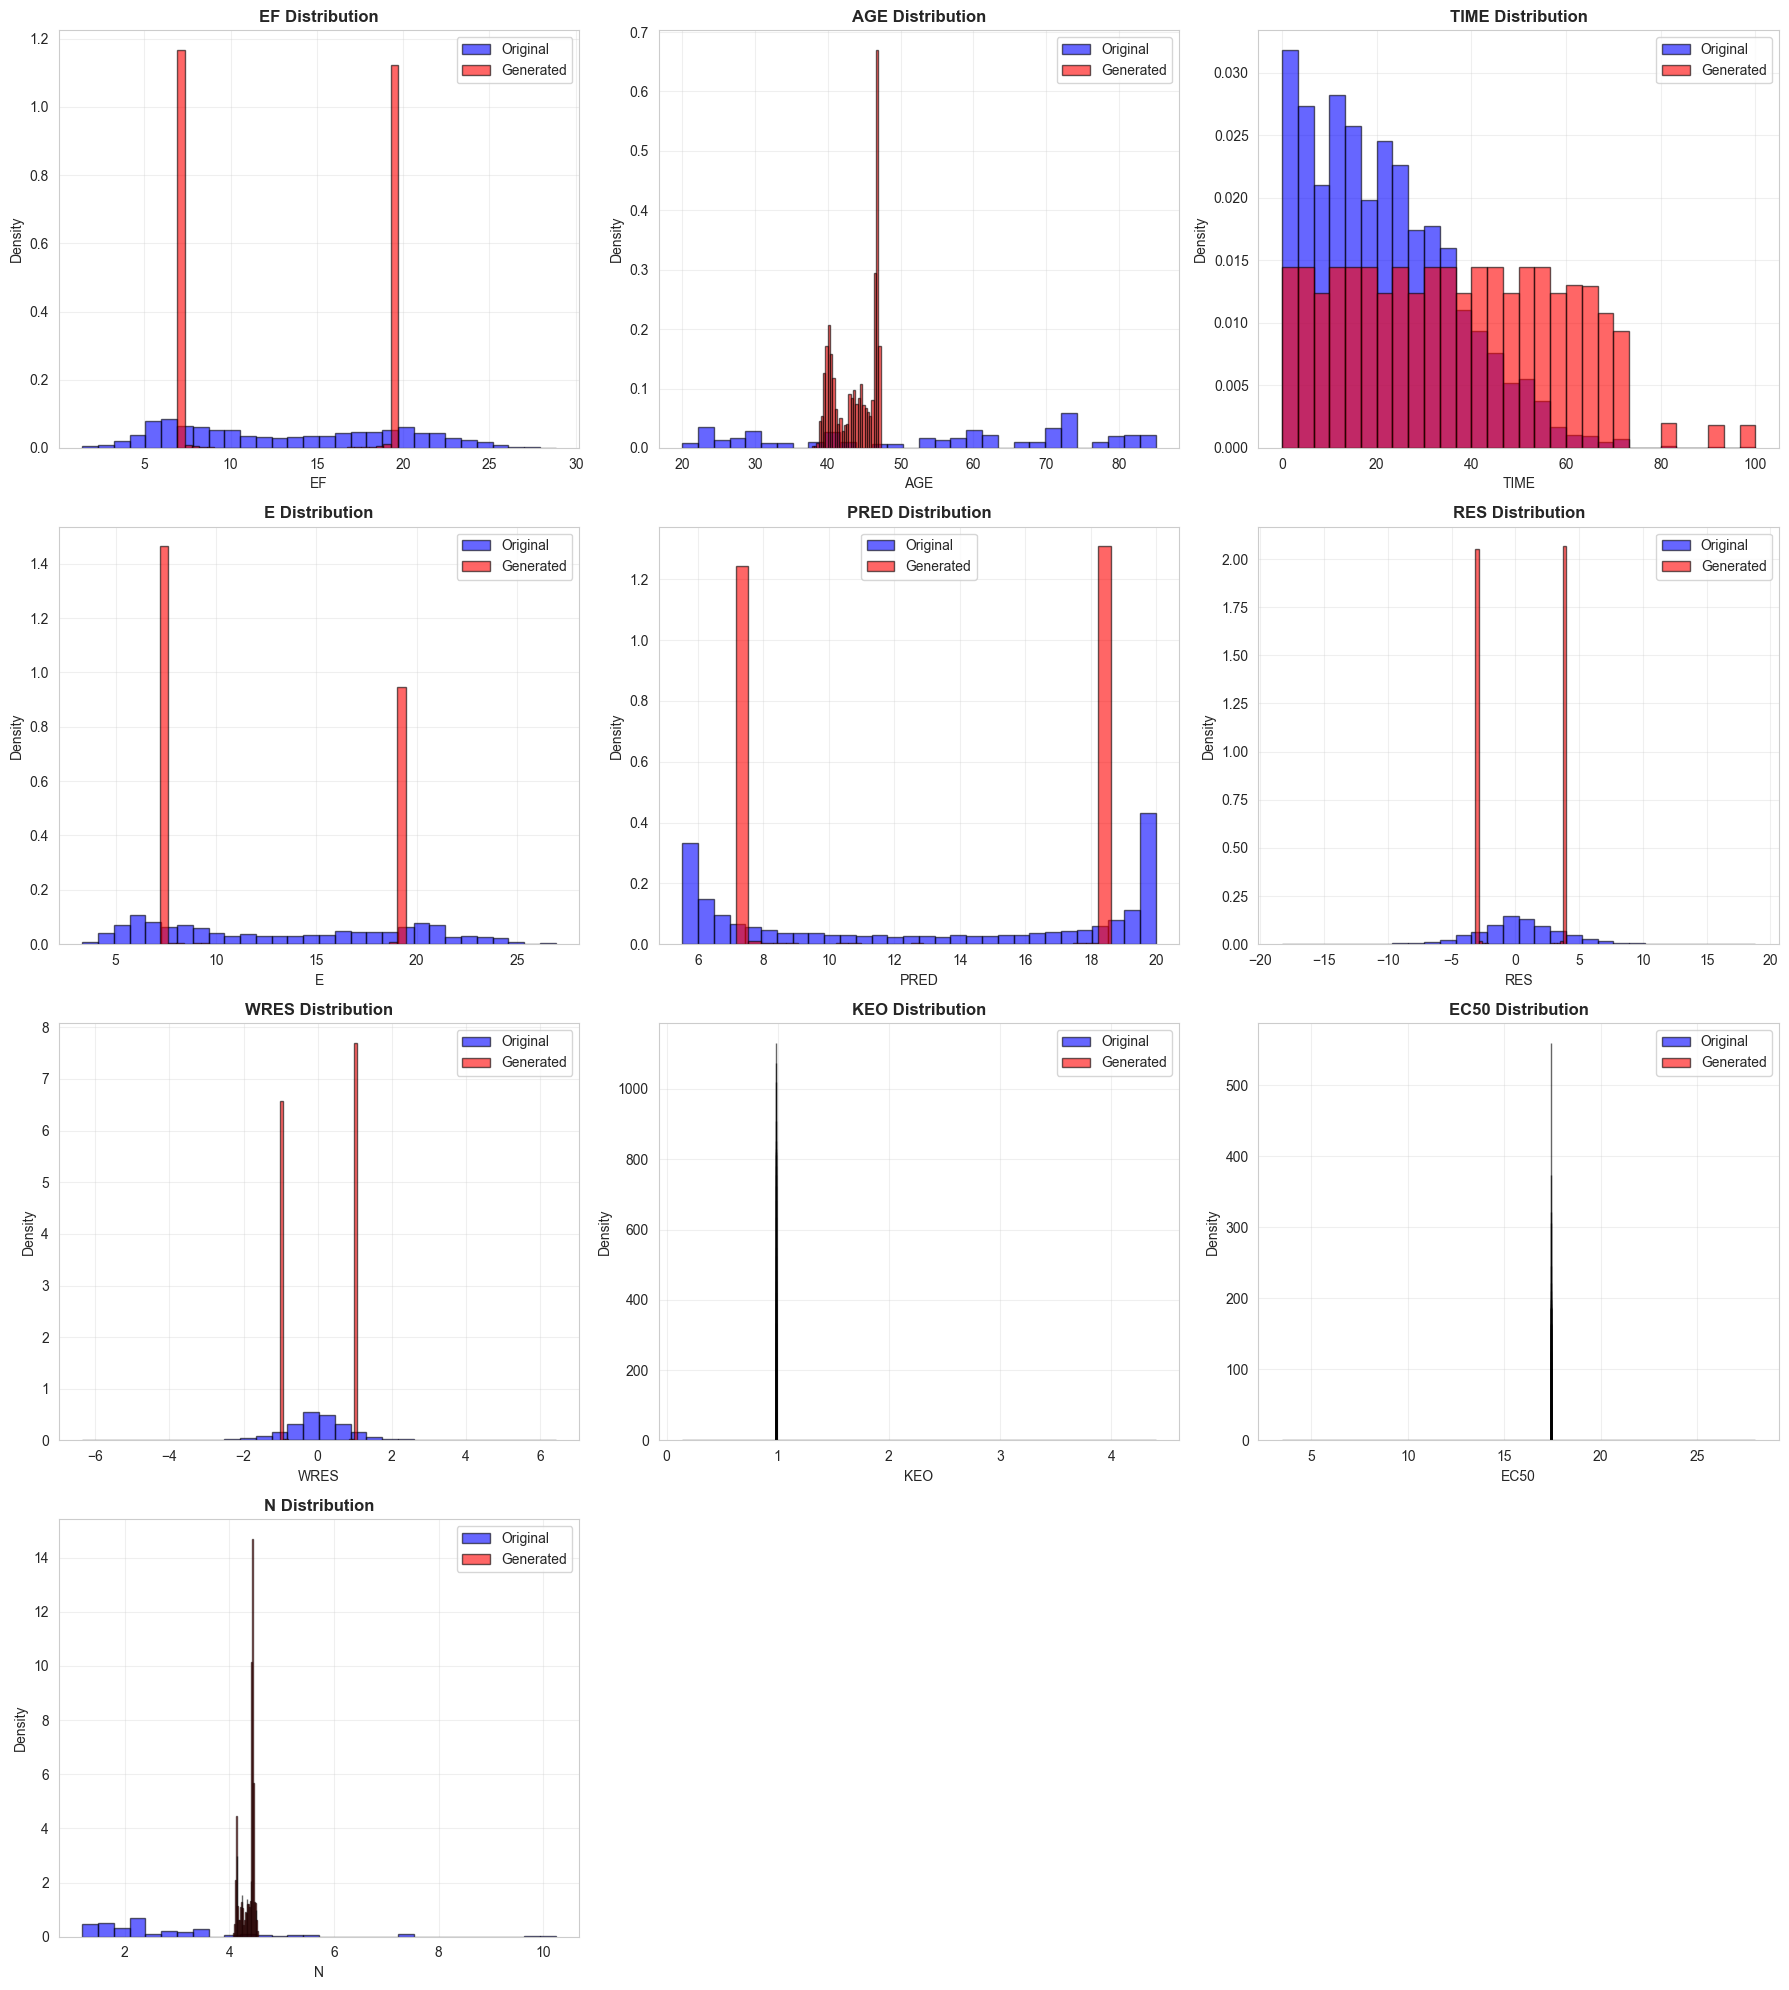

In [20]:
# ============================================================================
# VISUAL DISTRIBUTION COMPARISON
# ============================================================================

# Select a subset of key features for visualization (to avoid too many plots)
# You can modify this list to focus on specific features
key_features = ['EF', 'AGE', 'TIME', 'E', 'PRED', 'RES', 'WRES', 'KEO', 'EC50', 'N']

# Filter to only include features that exist in both datasets
key_features = [f for f in key_features if f in feature_cols]

# 1. Histogram Comparison for Key Features
print("=" * 80)
print("VISUAL COMPARISON: Histograms")
print("=" * 80)

n_features = len(key_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

for idx, feature in enumerate(key_features):
    ax = axes[idx]
    
    # Plot histograms
    ax.hist(orig_df[feature].dropna(), bins=30, alpha=0.6, label='Original', 
            color='blue', density=True, edgecolor='black')
    ax.hist(synthetic_df[feature].dropna(), bins=30, alpha=0.6, label='Generated', 
            color='red', density=True, edgecolor='black')
    
    ax.set_title(f'{feature} Distribution', fontsize=12, fontweight='bold')
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide extra subplots
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()



VISUAL COMPARISON: Q-Q Plots
Q-Q plots show if two distributions are similar. Points should lie along the diagonal line.



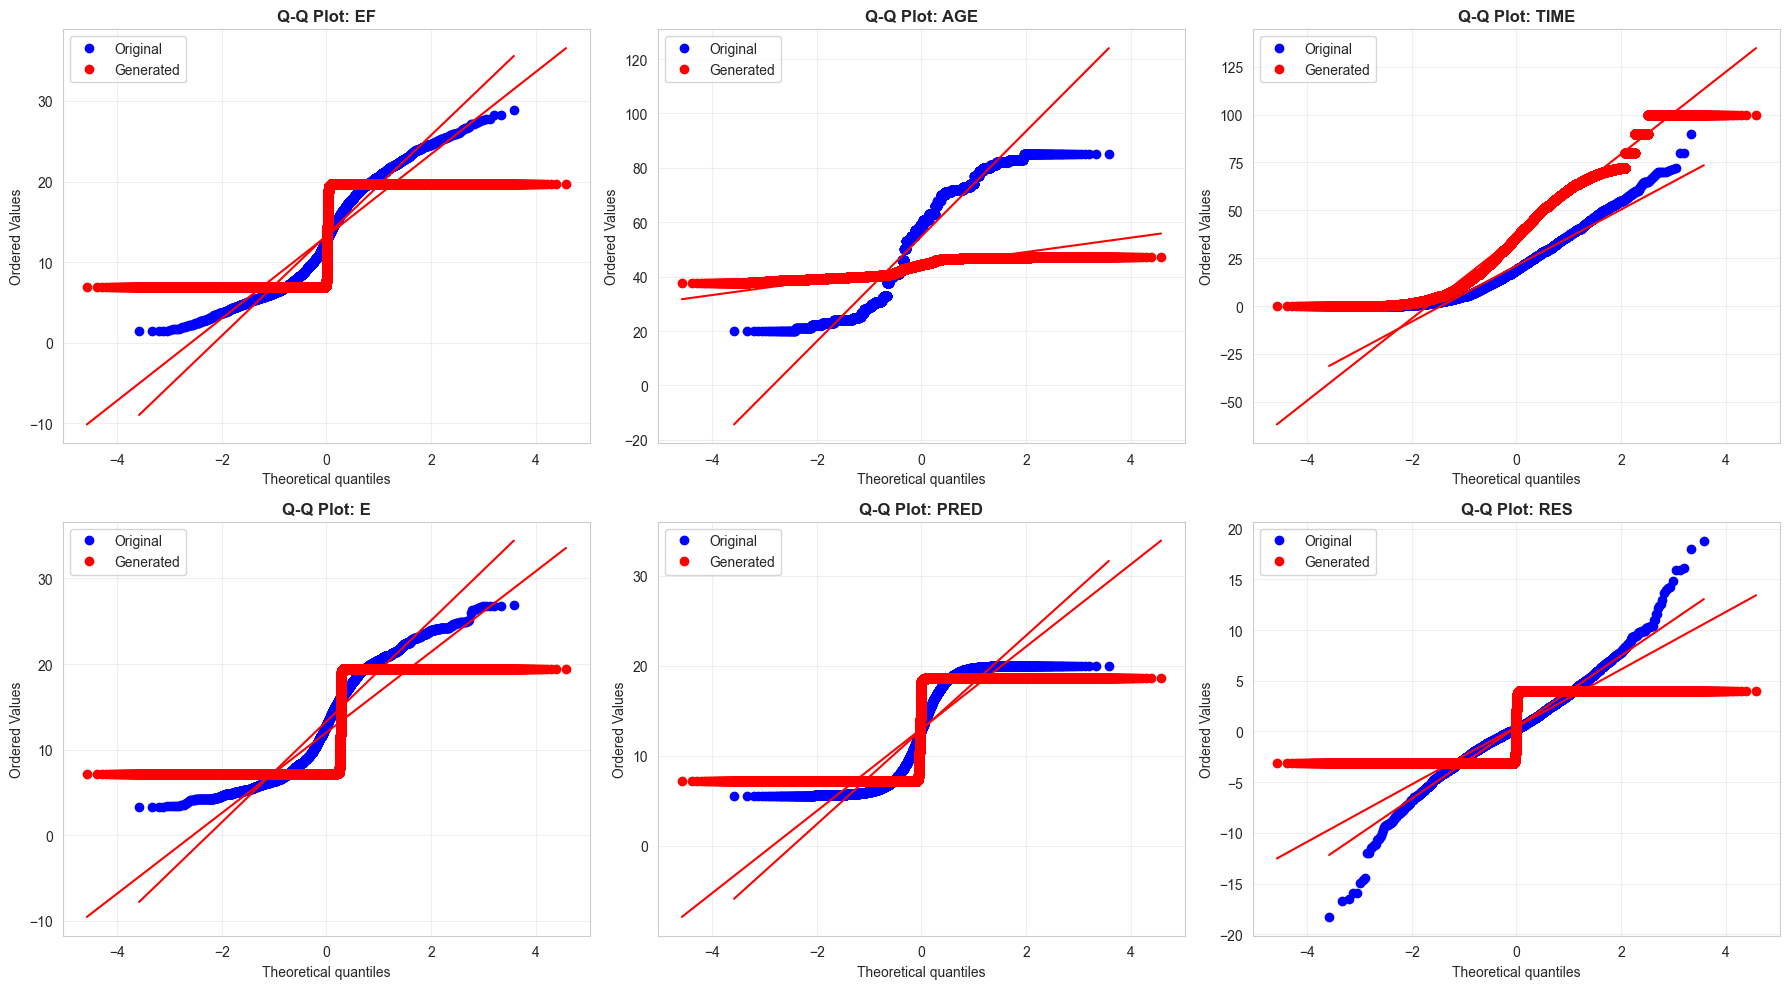

In [21]:

# 2. Q-Q Plots (Quantile-Quantile plots) for selected features
print("\n" + "=" * 80)
print("VISUAL COMPARISON: Q-Q Plots")
print("=" * 80)
print("Q-Q plots show if two distributions are similar. Points should lie along the diagonal line.\n")

n_features_qq = min(6, len(key_features))  # Show up to 6 Q-Q plots
n_cols_qq = 3
n_rows_qq = (n_features_qq + n_cols_qq - 1) // n_cols_qq

fig, axes = plt.subplots(n_rows_qq, n_cols_qq, figsize=(18, 5*n_rows_qq))
axes = axes.flatten() if n_features_qq > 1 else [axes]

for idx, feature in enumerate(key_features[:n_features_qq]):
    ax = axes[idx]
    
    orig_vals = orig_df[feature].dropna().values
    synth_vals = synthetic_df[feature].dropna().values
    
    # Create Q-Q plot
    stats.probplot(orig_vals, dist="norm", plot=ax)
    ax.get_lines()[0].set_markerfacecolor('blue')
    ax.get_lines()[0].set_markeredgecolor('blue')
    ax.get_lines()[0].set_label('Original')
    
    # Overlay generated data
    stats.probplot(synth_vals, dist="norm", plot=ax)
    ax.get_lines()[2].set_markerfacecolor('red')
    ax.get_lines()[2].set_markeredgecolor('red')
    ax.get_lines()[2].set_label('Generated')
    
    ax.set_title(f'Q-Q Plot: {feature}', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide extra subplots
for idx in range(n_features_qq, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()



VISUAL COMPARISON: Box Plots


/var/folders/8q/3b1t_h8s4fbbzmff1v1jg1_40000gn/T/ipykernel_2208/2091239324.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Original', 'Generated'], patch_artist=True)
/var/folders/8q/3b1t_h8s4fbbzmff1v1jg1_40000gn/T/ipykernel_2208/2091239324.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Original', 'Generated'], patch_artist=True)
/var/folders/8q/3b1t_h8s4fbbzmff1v1jg1_40000gn/T/ipykernel_2208/2091239324.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Original', 'Generated'], patch_artis

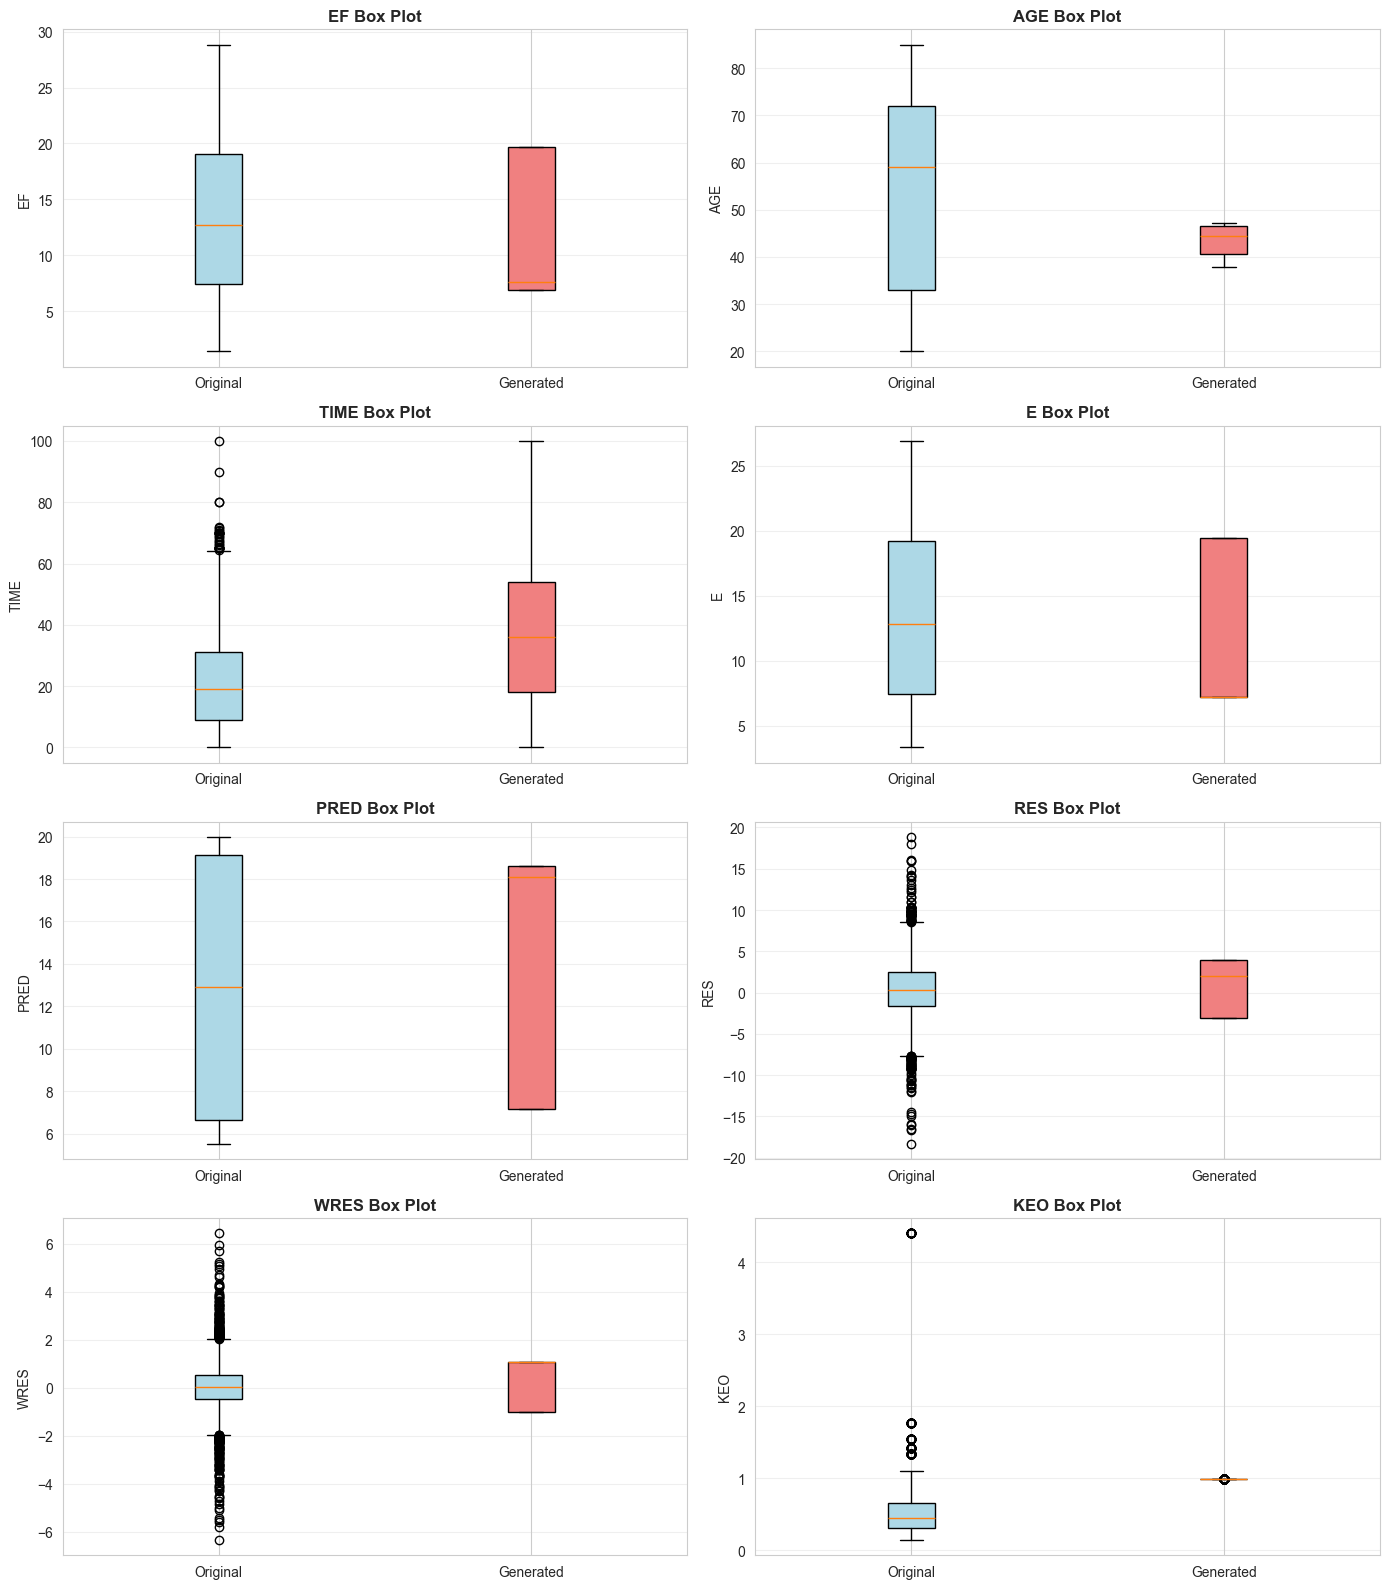

In [22]:

# 3. Box Plot Comparison
print("\n" + "=" * 80)
print("VISUAL COMPARISON: Box Plots")
print("=" * 80)

n_features_box = min(8, len(key_features))
n_cols_box = 2
n_rows_box = (n_features_box + n_cols_box - 1) // n_cols_box

fig, axes = plt.subplots(n_rows_box, n_cols_box, figsize=(14, 4*n_rows_box))
axes = axes.flatten() if n_features_box > 1 else [axes]

for idx, feature in enumerate(key_features[:n_features_box]):
    ax = axes[idx]
    
    data_to_plot = [orig_df[feature].dropna().values, synthetic_df[feature].dropna().values]
    bp = ax.boxplot(data_to_plot, labels=['Original', 'Generated'], patch_artist=True)
    
    # Color the boxes
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightcoral')
    
    ax.set_title(f'{feature} Box Plot', fontsize=12, fontweight='bold')
    ax.set_ylabel(feature)
    ax.grid(True, alpha=0.3, axis='y')

# Hide extra subplots
for idx in range(n_features_box, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()



VISUAL COMPARISON: Correlation Matrices


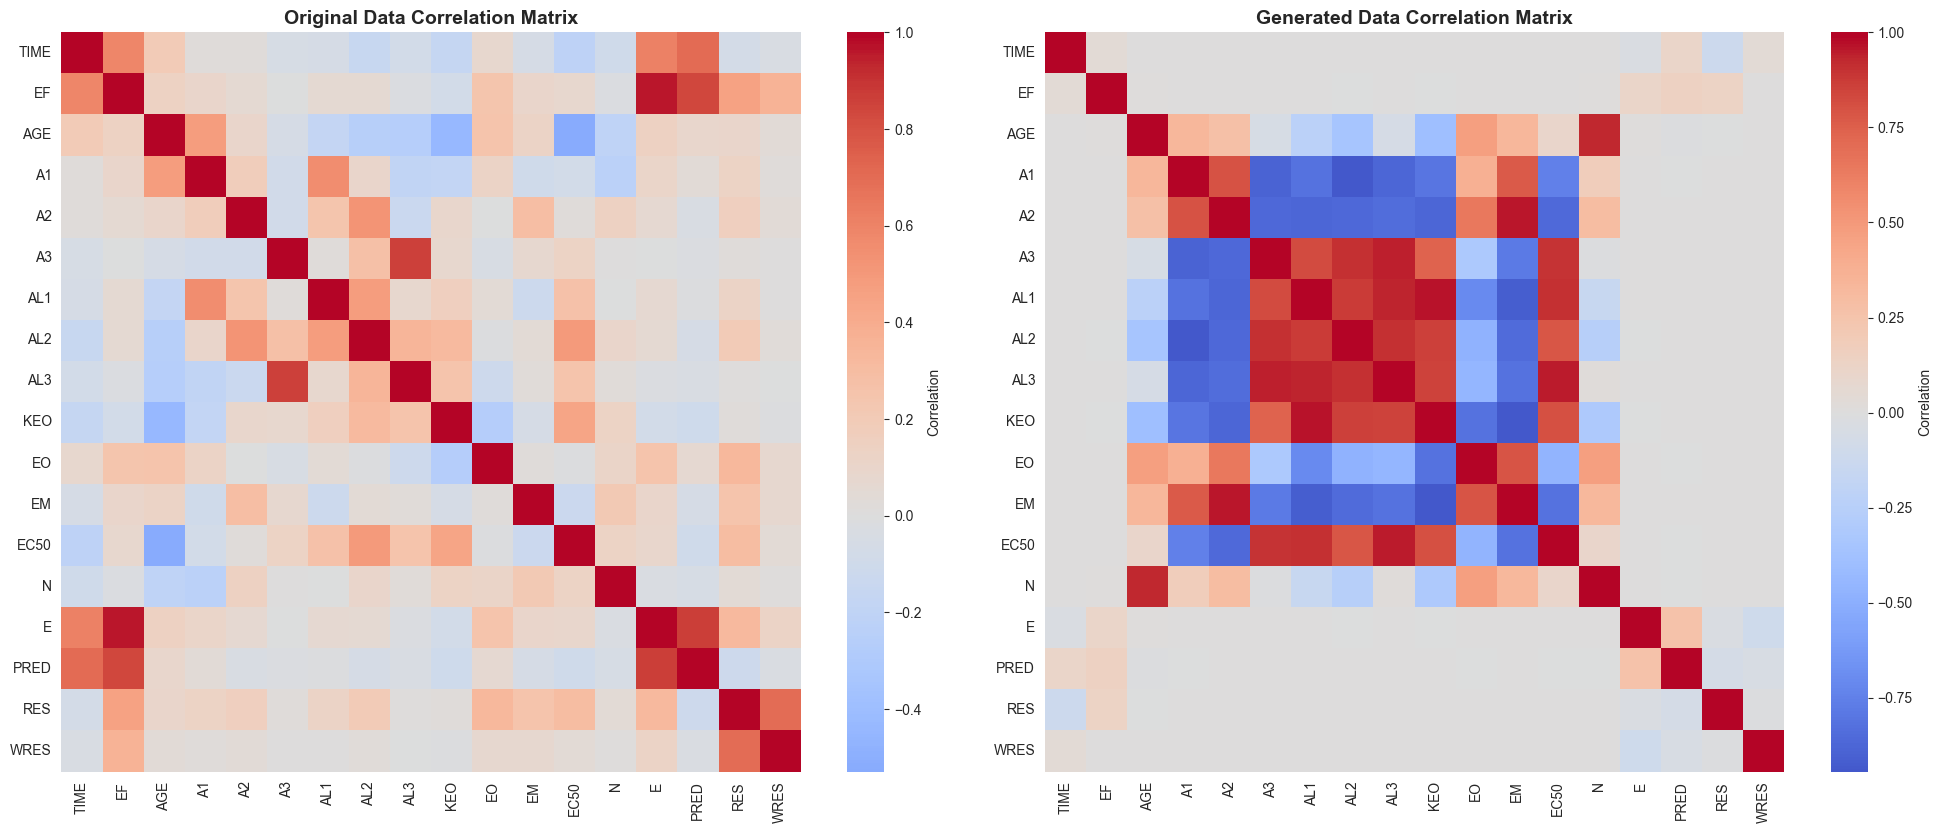

In [23]:

# 4. Correlation Heatmap Comparison
print("\n" + "=" * 80)
print("VISUAL COMPARISON: Correlation Matrices")
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Original correlation
sns.heatmap(orig_corr, annot=False, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', ax=axes[0], cbar_kws={'label': 'Correlation'})
axes[0].set_title('Original Data Correlation Matrix', fontsize=14, fontweight='bold')

# Generated correlation
sns.heatmap(synth_corr, annot=False, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', ax=axes[1], cbar_kws={'label': 'Correlation'})
axes[1].set_title('Generated Data Correlation Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


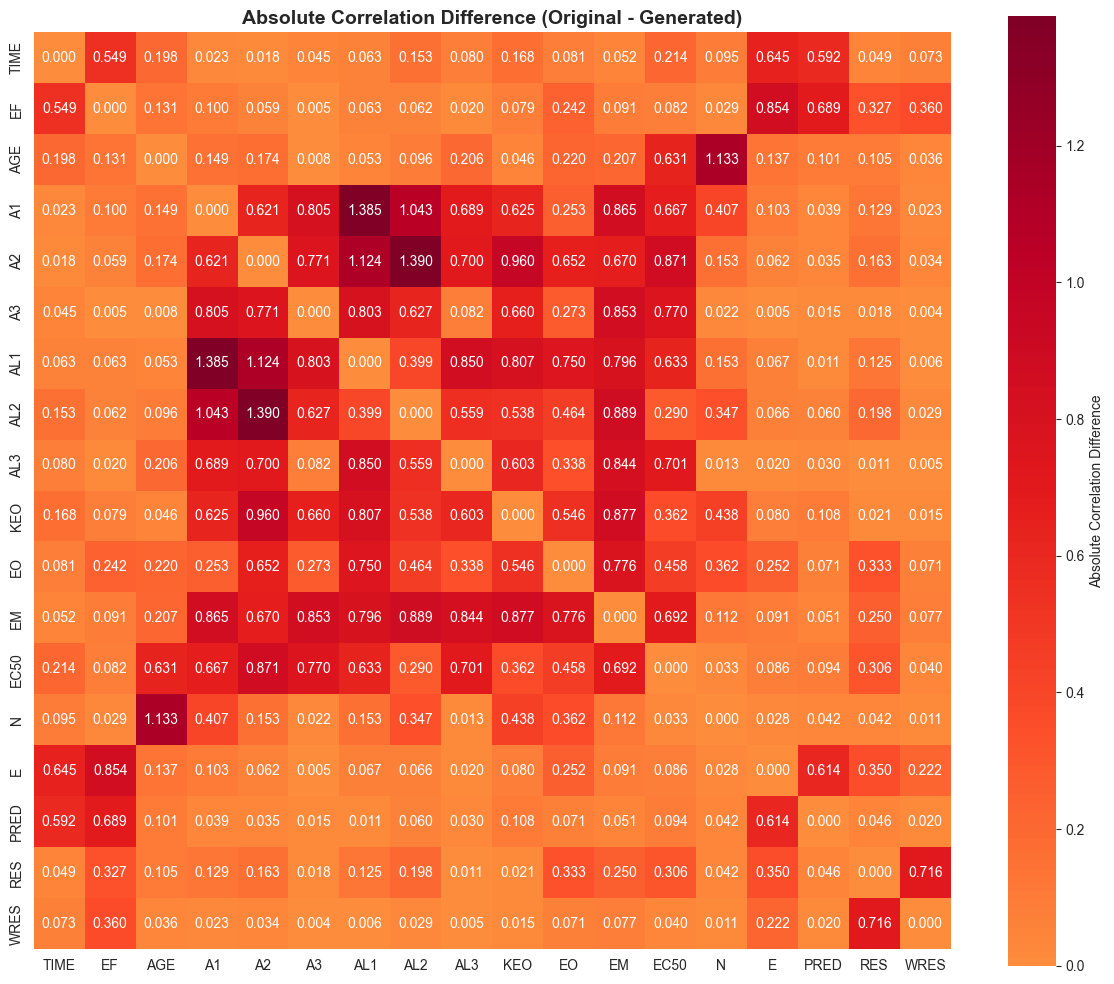

In [24]:

# Correlation difference heatmap
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(corr_diff, annot=True, cmap='YlOrRd', center=0, 
            square=True, fmt='.3f', ax=ax, cbar_kws={'label': 'Absolute Correlation Difference'})
ax.set_title('Absolute Correlation Difference (Original - Generated)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()



VISUAL COMPARISON: Time Series (averaged across individuals)


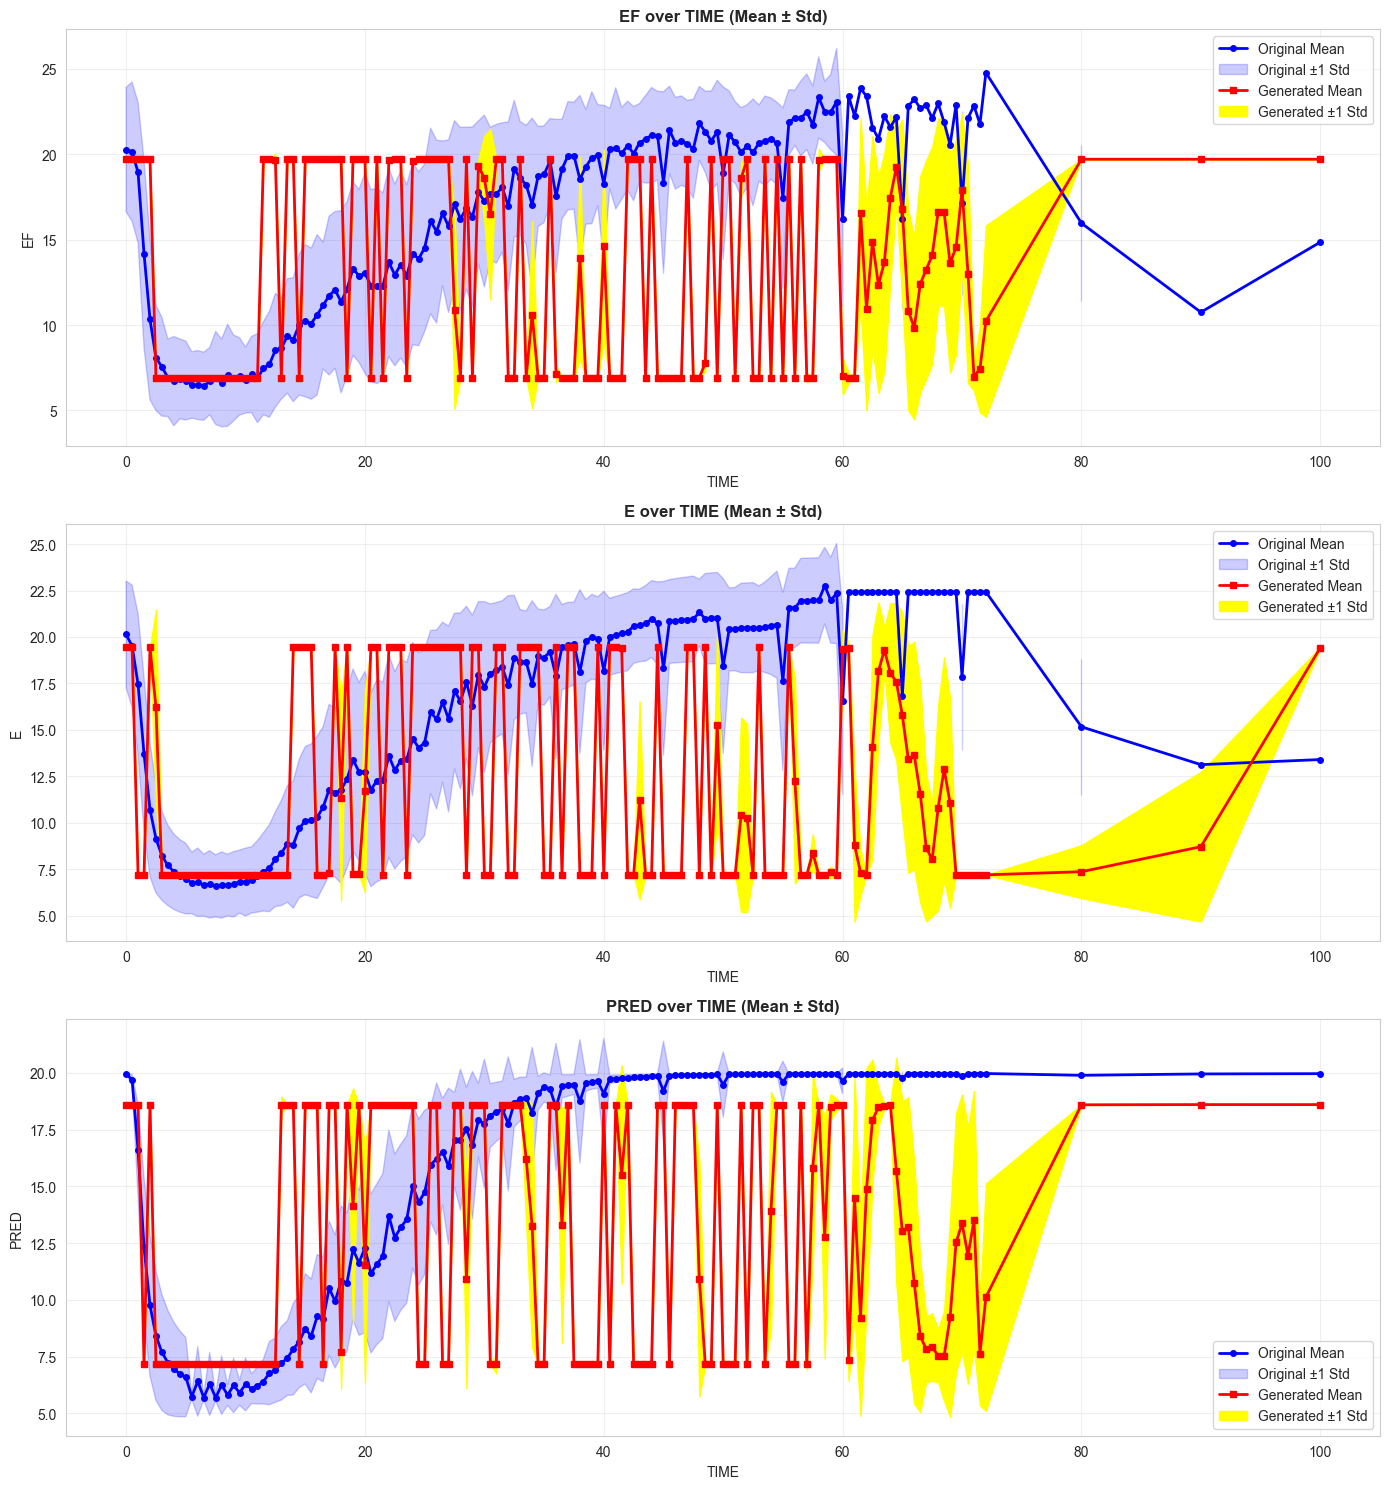

In [25]:

# 5. Time Series Comparison (for a few key features over TIME)
print("\n" + "=" * 80)
print("VISUAL COMPARISON: Time Series (averaged across individuals)")
print("=" * 80)

if 'TIME' in feature_cols:
    time_features = ['EF', 'E', 'PRED']  # Features that vary over time
    time_features = [f for f in time_features if f in feature_cols]
    
    if time_features:
        n_time_features = len(time_features)
        fig, axes = plt.subplots(n_time_features, 1, figsize=(14, 5*n_time_features))
        if n_time_features == 1:
            axes = [axes]
        
        # Round synthetic TIME to nearest 0.5, set negative times to 0, and cap at 100 (once before loop)
        synthetic_df_copy = synthetic_df.copy()
        synthetic_df_copy['TIME_ROUNDED'] = np.round(synthetic_df_copy['TIME'] * 2) / 2
        synthetic_df_copy['TIME_ROUNDED'] = np.maximum(synthetic_df_copy['TIME_ROUNDED'], 0)
        synthetic_df_copy['TIME_ROUNDED'] = np.minimum(synthetic_df_copy['TIME_ROUNDED'], 100)
        
        for idx, feature in enumerate(time_features):
            ax = axes[idx]
            
            # Group by TIME and calculate mean for original data
            orig_time_mean = orig_df.groupby('TIME')[feature].mean().reset_index()
            orig_time_std = orig_df.groupby('TIME')[feature].std().reset_index()
            
            # Group by rounded TIME and calculate mean for generated data
            synth_time_mean = synthetic_df_copy.groupby('TIME_ROUNDED')[feature].mean().reset_index()
            synth_time_mean = synth_time_mean.rename(columns={'TIME_ROUNDED': 'TIME'})
            synth_time_std = synthetic_df_copy.groupby('TIME_ROUNDED')[feature].std().reset_index()
            synth_time_std = synth_time_std.rename(columns={'TIME_ROUNDED': 'TIME'})
            
            # Plot with error bars (std)
            ax.plot(orig_time_mean['TIME'], orig_time_mean[feature], 
                   'o-', label='Original Mean', color='blue', linewidth=2, markersize=4)
            ax.fill_between(orig_time_mean['TIME'], 
                           orig_time_mean[feature] - orig_time_std[feature],
                           orig_time_mean[feature] + orig_time_std[feature],
                           alpha=0.2, color='blue', label='Original ±1 Std')
            
            ax.plot(synth_time_mean['TIME'], synth_time_mean[feature], 
                   's-', label='Generated Mean', color='red', linewidth=2, markersize=4, alpha=1)
            ax.fill_between(synth_time_mean['TIME'], 
                           synth_time_mean[feature] - synth_time_std[feature],
                           synth_time_mean[feature] + synth_time_std[feature],
                           alpha=1, color='yellow', label='Generated ±1 Std')
            
            ax.set_xlabel('TIME')
            ax.set_ylabel(feature)
            ax.set_title(f'{feature} over TIME (Mean ± Std)', fontsize=12, fontweight='bold')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()



VISUAL ORIG DATA: Time Series (averaged across individuals)


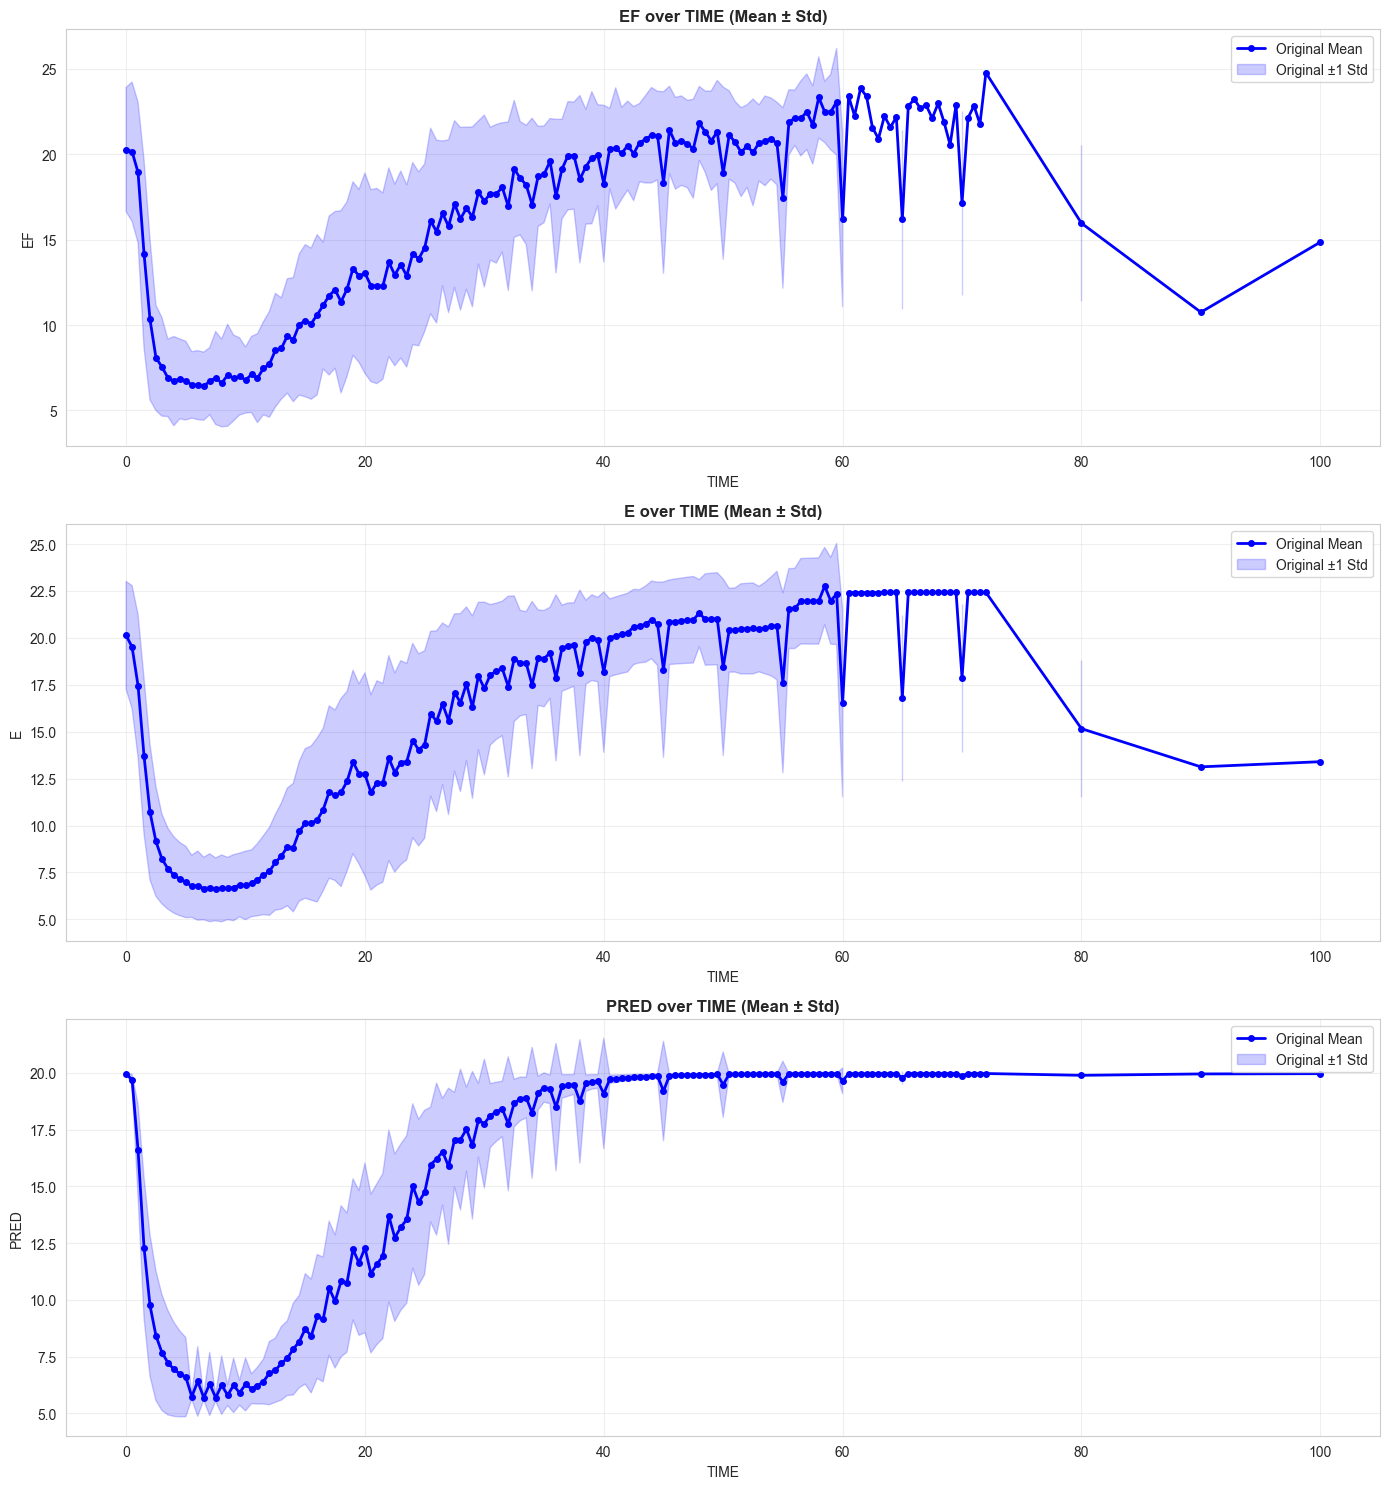

In [26]:

# 6. Time Series of original data alone
print("\n" + "=" * 80)
print("VISUAL ORIG DATA: Time Series (averaged across individuals)")
print("=" * 80)

if 'TIME' in feature_cols:
    time_features = ['EF', 'E', 'PRED']  # Features that vary over time
    time_features = [f for f in time_features if f in feature_cols]
    
    if time_features:
        n_time_features = len(time_features)
        fig, axes = plt.subplots(n_time_features, 1, figsize=(14, 5*n_time_features))
        if n_time_features == 1:
            axes = [axes]
        
        # Round synthetic TIME to nearest 0.5, set negative times to 0, and cap at 100 (once before loop)
        synthetic_df_copy = synthetic_df.copy()
        synthetic_df_copy['TIME_ROUNDED'] = np.round(synthetic_df_copy['TIME'] * 2) / 2
        synthetic_df_copy['TIME_ROUNDED'] = np.maximum(synthetic_df_copy['TIME_ROUNDED'], 0)
        synthetic_df_copy['TIME_ROUNDED'] = np.minimum(synthetic_df_copy['TIME_ROUNDED'], 100)
        
        for idx, feature in enumerate(time_features):
            ax = axes[idx]
            
            # Group by TIME and calculate mean for original data
            orig_time_mean = orig_df.groupby('TIME')[feature].mean().reset_index()
            orig_time_std = orig_df.groupby('TIME')[feature].std().reset_index()
            
            # Group by rounded TIME and calculate mean for generated data
            synth_time_mean = synthetic_df_copy.groupby('TIME_ROUNDED')[feature].mean().reset_index()
            synth_time_mean = synth_time_mean.rename(columns={'TIME_ROUNDED': 'TIME'})
            synth_time_std = synthetic_df_copy.groupby('TIME_ROUNDED')[feature].std().reset_index()
            synth_time_std = synth_time_std.rename(columns={'TIME_ROUNDED': 'TIME'})
            
            # Plot with error bars (std)
            ax.plot(orig_time_mean['TIME'], orig_time_mean[feature], 
                   'o-', label='Original Mean', color='blue', linewidth=2, markersize=4)
            ax.fill_between(orig_time_mean['TIME'], 
                           orig_time_mean[feature] - orig_time_std[feature],
                           orig_time_mean[feature] + orig_time_std[feature],
                           alpha=0.2, color='blue', label='Original ±1 Std')
            
            ax.set_xlabel('TIME')
            ax.set_ylabel(feature)
            ax.set_title(f'{feature} over TIME (Mean ± Std)', fontsize=12, fontweight='bold')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


In [27]:

print("\n" + "=" * 80)
print("Visual comparison complete!")
print("=" * 80)



Visual comparison complete!


PKPD modelling

<>:39: SyntaxWarning: invalid escape sequence '\s'
<>:39: SyntaxWarning: invalid escape sequence '\s'
/var/folders/8q/3b1t_h8s4fbbzmff1v1jg1_40000gn/T/ipykernel_2208/288969793.py:39: SyntaxWarning: invalid escape sequence '\s'
  sep='\s+',     # Use one or more spaces as a separator


Data loaded from /Users/srikanthchandar/Downloads/KEO2.TBL. Total observations: 3989

--- Running PD Simulation (Re-calculating EEG Effect) ---
Mean Squared Error (EF vs. EF_SIM): 72.7158
Validation MSE (EF_PRED vs. EF_SIM, checking function match): 72.71582400

Goodness-of-Fit plot saved to 'minto_pkpd_gof.png'.
Residual plot saved to 'minto_pkpd_residuals.png'.
Concentration-Effect plot for one individual saved to 'minto_pkpd_ce.png'.


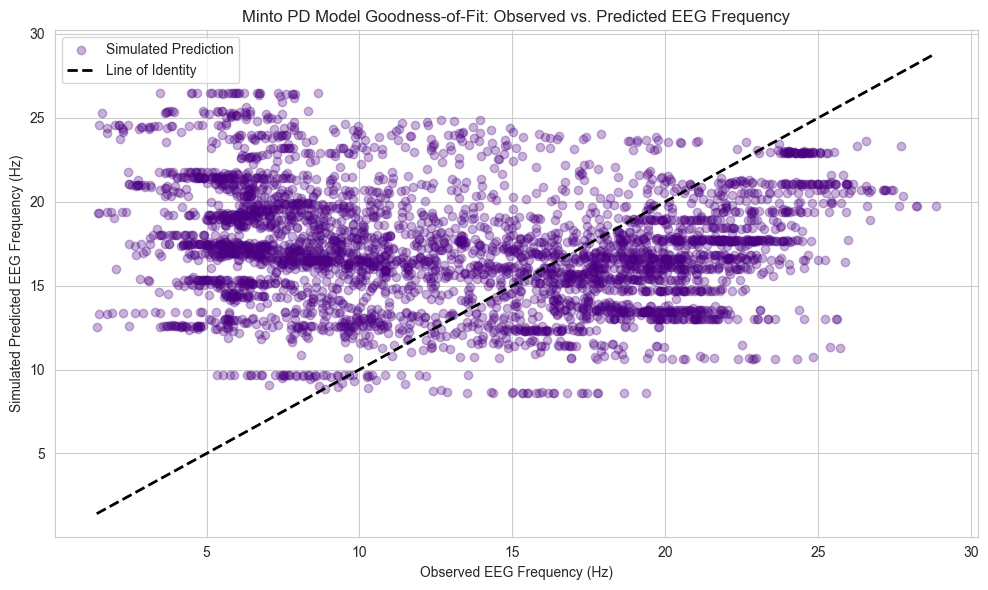

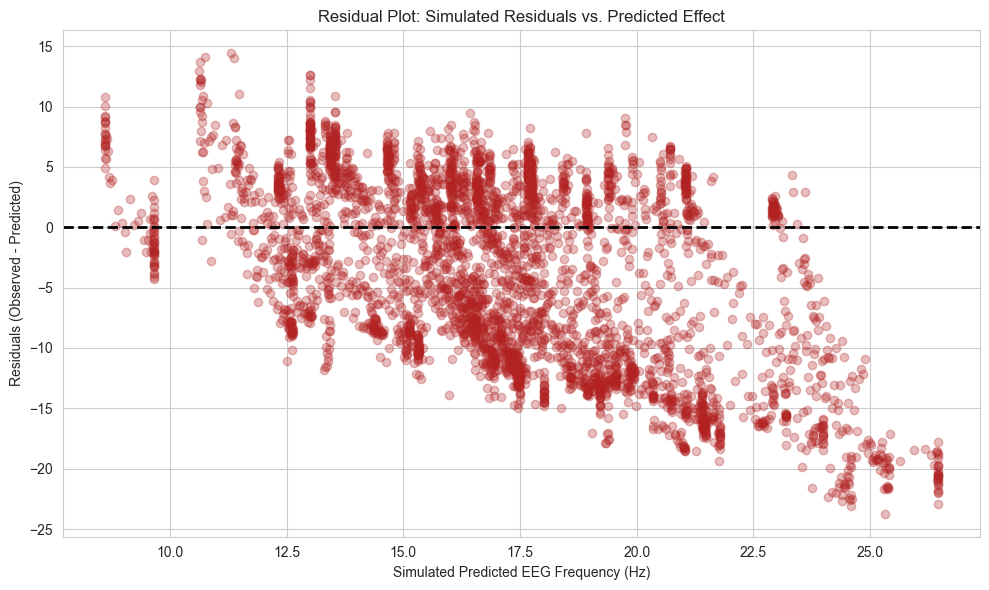

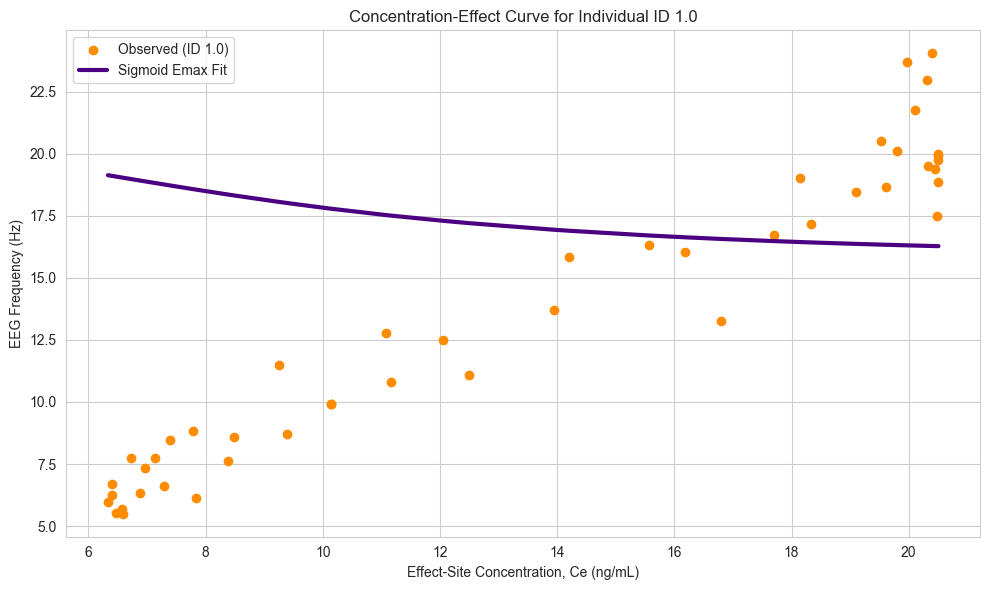

In [28]:
# -*- coding: utf-8 -*-
"""
Minto PK/PD Simulation (Sigmoid Emax Model)

This script performs a pure Pharmacodynamic (PD) simulation by taking the 
individual predicted PK/PD parameters and effect-site concentrations derived
from the original NONMEM run (available in KEO2.TBL) and uses the final 
Sigmoid Emax equation to re-calculate the predicted effect (EEG Frequency).

This allows us to visualize the model's performance without requiring NONMEM.
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

# --- CONFIGURATION ---
FILE_PATH = "/Users/srikanthchandar/Downloads/KEO2.TBL"

# --- 1. Load and Preprocess Data ---

def load_minto_data(file_path):
    """Loads the KEO2.TBL file and prepares the dataframe for PD simulation."""
    
    # Column names based on the KEO2.TBL header structure provided by the user
    NAMES = ['ID', 'TIME', 'EF', 'AGE', 'A1', 'A2', 'A3', 'AL1', 'AL2', 'AL3', 
             'KEO', 'EO', 'EM', 'EC50', 'N', 'E', 'EF_PRED', 'PRED', 'RES', 'WRES']
    
    # List of columns needed for the PD calculation and plotting
    COLUMNS_NEEDED = ['ID', 'TIME', 'EF', 'E', 'EO', 'EM', 'EC50', 'N', 'EF_PRED', 'AGE', 'RES']
    df = pd.DataFrame() # Initialize empty DataFrame
    
    try:
        # Strategy 1: Read starting from the data lines (skipping the first 2 metadata lines)
        df = pd.read_csv(
            file_path,
            skiprows=2,    # Skip 'TABLE NO...' and the column names line (robust start)
            sep='\s+',     # Use one or more spaces as a separator
            header=None,   # No header row in the data chunk
            index_col=False
        )
        
        # NONMEM data lines often start with a space, so read_csv creates an extra NaN column [0].
        # We drop the first column if the number of columns exceeds the expected NAMES count.
        if df.shape[1] > len(NAMES):
            df = df.iloc[:, 1:]

        # Check if the remaining columns match the expected length
        if df.shape[1] == len(NAMES):
            df.columns = NAMES
        else:
            raise ValueError(f"Space-separated read failed: Expected {len(NAMES)} columns, got {df.shape[1]}.")
        
    except Exception as e:
        # Fallback to robust fixed-width parsing if Strategy 1 fails
        print(f"Error reading file with Strategy 1 ({df.shape[1]} columns detected): {e}")
        print("Attempting Strategy 2: Fixed-width parsing...")
        
        # Fallback for robust parsing of typical NONMEM output format (Fixed Width)
        # We assume 10 characters per field for the 20 fields
        colspecs = [(i*10, (i+1)*10) for i in range(len(NAMES))]
        
        # This fixed-width read uses the column names line as the header (index 1)
        df = pd.read_fwf(file_path, colspecs=colspecs, names=NAMES, header=1, skiprows=[0, 2])
        
    
    # --- CRITICAL STEP: Ensure all columns are converted to numeric ---
    if not df.empty:
        for col in COLUMNS_NEEDED:
             if col in df.columns:
                # Coerce errors means any non-numeric value becomes NaN
                df[col] = pd.to_numeric(df[col], errors='coerce')

    # Select necessary columns and drop any remaining non-numeric or missing rows
    df_clean = df[COLUMNS_NEEDED].dropna()
    
    if df_clean.empty:
        print("\nFATAL ERROR: Dataframe is still empty after parsing. Check the file format.")
    
    print(f"Data loaded from {file_path}. Total observations: {len(df_clean)}")
    return df_clean

# The rest of the script (steps 2-5) remains unchanged as the functions themselves are correct.
df = load_minto_data(FILE_PATH)

# --- 2. Define the Sigmoid Emax Model Function ---

def sigmoid_emax(Ce, E0, Emax, EC50, N):
    """
    Calculates the predicted effect (E) using the Minto Sigmoid Emax model.
    E = E0 - (Emax * Ce^N) / (EC50^N + Ce^N)
    
    Ce: Effect-site concentration (E in the data)
    E0: Baseline effect (EO in the data)
    Emax: Maximum possible effect decrease (EM in the data)
    EC50: Concentration for 50% Emax (EC50 in the data)
    N: Hill coefficient (N in the data)
    """
    # Use numpy.power for element-wise power calculation on columns/series
    Ce_N = np.power(Ce, N)
    EC50_N = np.power(EC50, N)
    
    # Calculate the change in effect (Delta E)
    delta_E = (Emax * Ce_N) / (EC50_N + Ce_N)
    
    # Final predicted effect
    predicted_effect = E0 - delta_E
    
    return predicted_effect

# --- 3. Run the PD Simulation ---

print("\n--- Running PD Simulation (Re-calculating EEG Effect) ---")

# Apply the Sigmoid Emax function across every row using the individual parameters
df['EF_SIM'] = sigmoid_emax(
    Ce=df['E'],
    E0=df['EO'],
    Emax=df['EM'],
    EC50=df['EC50'],
    N=df['N']
)

# --- 4. Evaluate Performance ---

if not df.empty:
    # 1. Compare our simulation to the original observed data (EF)
    mse_sim = mean_squared_error(df['EF'], df['EF_SIM'])

    # 2. Compare our simulation to the original predicted data (EF_PRED)
    mse_match = mean_squared_error(df['EF_PRED'], df['EF_SIM'])

    print(f"Mean Squared Error (EF vs. EF_SIM): {mse_sim:.4f}")
    print(f"Validation MSE (EF_PRED vs. EF_SIM, checking function match): {mse_match:.8f}")

    # --- 5. Visualization: Goodness-of-Fit Plot (Observed vs. Predicted) ---

    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))

    # Plot Observed EEG (EF) vs. Simulated Predicted EEG (EF_SIM)
    plt.scatter(df['EF'], df['EF_SIM'], alpha=0.3, color='indigo', label='Simulated Prediction')

    # Plot the Line of Identity (LOI)
    min_val = min(df['EF'].min(), df['EF_SIM'].min())
    max_val = max(df['EF'].max(), df['EF_SIM'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Line of Identity')

    plt.title('Minto PD Model Goodness-of-Fit: Observed vs. Predicted EEG Frequency')
    plt.xlabel('Observed EEG Frequency (Hz)')
    plt.ylabel('Simulated Predicted EEG Frequency (Hz)')
    plt.legend()
    plt.tight_layout()
    plt.savefig('minto_pkpd_gof.png')
    print("\nGoodness-of-Fit plot saved to 'minto_pkpd_gof.png'.")

    # --- 6. Visualization: Residual Plot (Diagnostics) ---
    plt.figure(figsize=(10, 6))

    # Calculate Residuals (Observed - Predicted)
    df['RES_SIM'] = df['EF'] - df['EF_SIM']

    # Plot Residuals vs. Predicted (EF_SIM)
    plt.scatter(df['EF_SIM'], df['RES_SIM'], alpha=0.3, color='firebrick')

    # Plot the Line of Zero (LOZ)
    plt.axhline(0, color='k', linestyle='--', lw=2)

    plt.title('Residual Plot: Simulated Residuals vs. Predicted Effect')
    plt.xlabel('Simulated Predicted EEG Frequency (Hz)')
    plt.ylabel('Residuals (Observed - Predicted)')
    plt.tight_layout()
    plt.savefig('minto_pkpd_residuals.png')
    print("Residual plot saved to 'minto_pkpd_residuals.png'.")

    # Visualization: Concentration-Effect Plot for one individual
    individual_id = df['ID'].iloc[0] # Take the first individual
    df_individual = df[df['ID'] == individual_id].sort_values('E')

    plt.figure(figsize=(10, 6))
    # Scatter of observed effect vs. concentration
    plt.scatter(df_individual['E'], df_individual['EF'], color='darkorange', label=f'Observed (ID {individual_id})')
    # Plot the simulated sigmoid curve
    plt.plot(df_individual['E'], df_individual['EF_SIM'], color='indigo', linewidth=3, label='Sigmoid Emax Fit')
    plt.title(f'Concentration-Effect Curve for Individual ID {individual_id}')
    plt.xlabel('Effect-Site Concentration, Ce (ng/mL)')
    plt.ylabel('EEG Frequency (Hz)')
    plt.legend()
    plt.tight_layout()
    plt.savefig('minto_pkpd_ce.png')
    print("Concentration-Effect plot for one individual saved to 'minto_pkpd_ce.png'.")
else:
    print("\nSkipping evaluation and plotting: The DataFrame is empty. Please verify your KEO2.TBL file.")


Data loaded from /Users/srikanthchandar/Downloads/KEO2.TBL. Total observations: 290000

--- Running PD Simulation (Re-calculating EEG Effect) ---
Mean Squared Error (EF vs. EF_SIM): 55.9591
Validation MSE (EF_PRED vs. EF_SIM, checking function match): 51.20909119

Goodness-of-Fit plot saved to 'minto_pkpd_gof.png'.
Residual plot saved to 'minto_pkpd_residuals.png'.
Concentration-Effect plot for one individual saved to 'minto_pkpd_ce.png'.


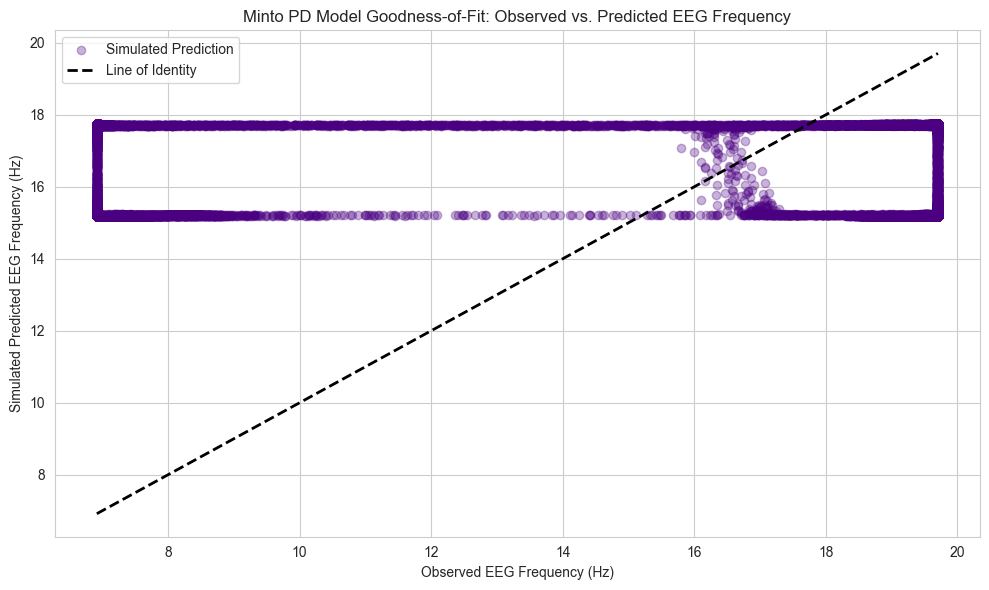

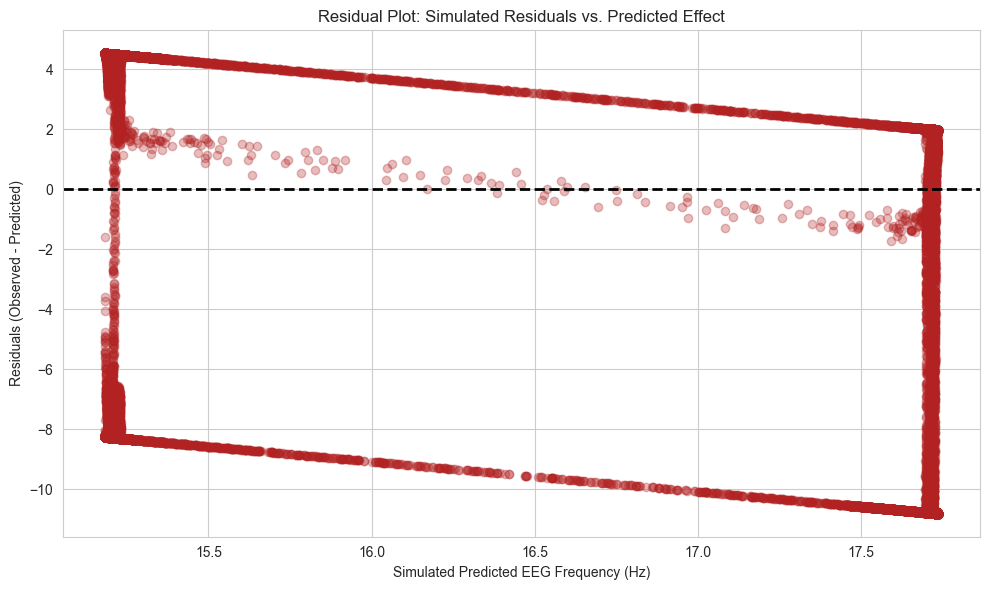

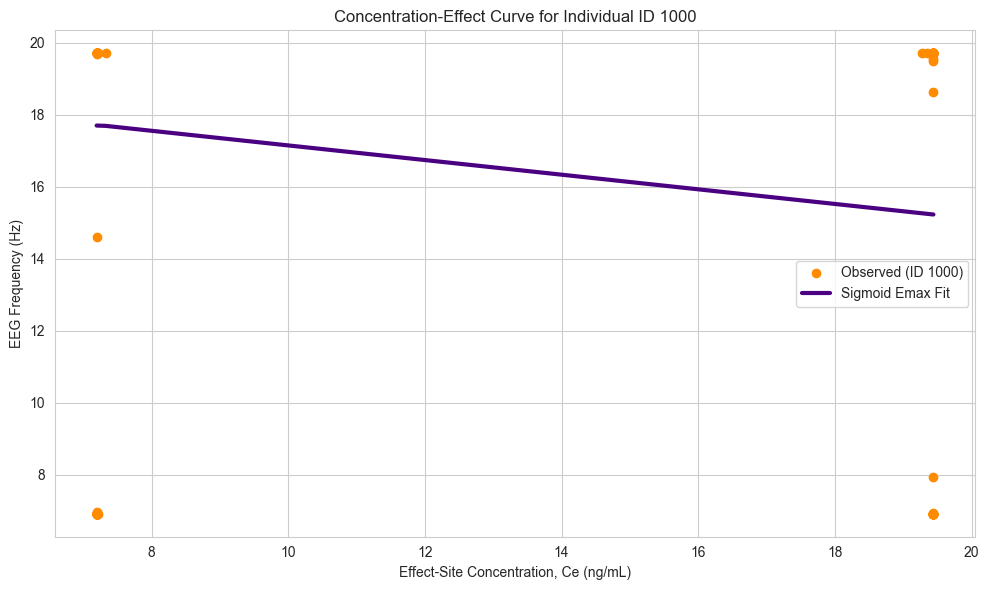

In [32]:
# -*- coding: utf-8 -*-
"""
Minto PK/PD Simulation (Sigmoid Emax Model)

This script performs a pure Pharmacodynamic (PD) simulation by taking the 
individual predicted PK/PD parameters and effect-site concentrations derived
from the original NONMEM run (available in KEO2.TBL) and uses the final 
Sigmoid Emax equation to re-calculate the predicted effect (EEG Frequency).

This allows us to visualize the model's performance without requiring NONMEM.
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

# --- CONFIGURATION ---
FILE_PATH = "/Users/srikanthchandar/Downloads/KEO2.TBL"

# --- 1. Load and Preprocess Data ---

def load_minto_data(file_path):
    """Loads the KEO2.TBL file and prepares the dataframe for PD simulation."""
    
    # Column names based on the KEO2.TBL header structure provided by the user
    NAMES = ['ID', 'TIME', 'EF', 'AGE', 'A1', 'A2', 'A3', 'AL1', 'AL2', 'AL3', 
             'KEO', 'EO', 'EM', 'EC50', 'N', 'E', 'EF_PRED', 'PRED', 'RES', 'WRES']
    
    # List of columns needed for the PD calculation and plotting
    COLUMNS_NEEDED = ['ID', 'TIME', 'EF', 'E', 'EO', 'EM', 'EC50', 'N', 'EF_PRED', 'AGE', 'RES']
    df = pd.DataFrame() # Initialize empty DataFrame
    
    try:
        # Strategy 1: Read starting from the data lines (skipping the first 2 metadata lines)
        # df = pd.read_csv(
        #     file_path,
        #     skiprows=2,    # Skip 'TABLE NO...' and the column names line (robust start)
        #     sep='\s+',     # Use one or more spaces as a separator
        #     header=None,   # No header row in the data chunk
        #     index_col=False
        # )
        df=synthetic_df
        
        # NONMEM data lines often start with a space, so read_csv creates an extra NaN column [0].
        # We drop the first column if the number of columns exceeds the expected NAMES count.
        if df.shape[1] > len(NAMES):
            df = df.iloc[:, 1:]

        # Check if the remaining columns match the expected length
        if df.shape[1] == len(NAMES):
            df.columns = NAMES
        else:
            raise ValueError(f"Space-separated read failed: Expected {len(NAMES)} columns, got {df.shape[1]}.")
        
    except Exception as e:
        # Fallback to robust fixed-width parsing if Strategy 1 fails
        print(f"Error reading file with Strategy 1 ({df.shape[1]} columns detected): {e}")
        print("Attempting Strategy 2: Fixed-width parsing...")
        
        # Fallback for robust parsing of typical NONMEM output format (Fixed Width)
        # We assume 10 characters per field for the 20 fields
        colspecs = [(i*10, (i+1)*10) for i in range(len(NAMES))]
        
        # This fixed-width read uses the column names line as the header (index 1)
        df = pd.read_fwf(file_path, colspecs=colspecs, names=NAMES, header=1, skiprows=[0, 2])
        
    
    # --- CRITICAL STEP: Ensure all columns are converted to numeric ---
    if not df.empty:
        for col in COLUMNS_NEEDED:
             if col in df.columns:
                # Coerce errors means any non-numeric value becomes NaN
                df[col] = pd.to_numeric(df[col], errors='coerce')

    # Select necessary columns and drop any remaining non-numeric or missing rows
    df_clean = df[COLUMNS_NEEDED].dropna()
    
    if df_clean.empty:
        print("\nFATAL ERROR: Dataframe is still empty after parsing. Check the file format.")
    
    print(f"Data loaded from {file_path}. Total observations: {len(df_clean)}")
    return df_clean


# The rest of the script (steps 2-5) remains unchanged as the functions themselves are correct.
df = load_minto_data(FILE_PATH)

# --- 2. Define the Sigmoid Emax Model Function ---

def sigmoid_emax(Ce, E0, Emax, EC50, N):
    """
    Calculates the predicted effect (E) using the Minto Sigmoid Emax model.
    E = E0 - (Emax * Ce^N) / (EC50^N + Ce^N)
    
    Ce: Effect-site concentration (E in the data)
    E0: Baseline effect (EO in the data)
    Emax: Maximum possible effect decrease (EM in the data)
    EC50: Concentration for 50% Emax (EC50 in the data)
    N: Hill coefficient (N in the data)
    """
    # Use numpy.power for element-wise power calculation on columns/series
    Ce_N = np.power(Ce, N)
    EC50_N = np.power(EC50, N)
    
    # Calculate the change in effect (Delta E)
    delta_E = (Emax * Ce_N) / (EC50_N + Ce_N)
    
    # Final predicted effect
    predicted_effect = E0 - delta_E
    
    return predicted_effect

# --- 3. Run the PD Simulation ---

print("\n--- Running PD Simulation (Re-calculating EEG Effect) ---")

# Apply the Sigmoid Emax function across every row using the individual parameters
df['EF_SIM'] = sigmoid_emax(
    Ce=df['E'],
    E0=df['EO'],
    Emax=df['EM'],
    EC50=df['EC50'],
    N=df['N']
)

# --- 4. Evaluate Performance ---

if not df.empty:
    # 1. Compare our simulation to the original observed data (EF)
    mse_sim = mean_squared_error(df['EF'], df['EF_SIM'])

    # 2. Compare our simulation to the original predicted data (EF_PRED)
    mse_match = mean_squared_error(df['EF_PRED'], df['EF_SIM'])

    print(f"Mean Squared Error (EF vs. EF_SIM): {mse_sim:.4f}")
    print(f"Validation MSE (EF_PRED vs. EF_SIM, checking function match): {mse_match:.8f}")

    # --- 5. Visualization: Goodness-of-Fit Plot (Observed vs. Predicted) ---

    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))

    # Plot Observed EEG (EF) vs. Simulated Predicted EEG (EF_SIM)
    plt.scatter(df['EF'], df['EF_SIM'], alpha=0.3, color='indigo', label='Simulated Prediction')

    # Plot the Line of Identity (LOI)
    min_val = min(df['EF'].min(), df['EF_SIM'].min())
    max_val = max(df['EF'].max(), df['EF_SIM'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Line of Identity')

    plt.title('Minto PD Model Goodness-of-Fit: Observed vs. Predicted EEG Frequency')
    plt.xlabel('Observed EEG Frequency (Hz)')
    plt.ylabel('Simulated Predicted EEG Frequency (Hz)')
    plt.legend()
    plt.tight_layout()
    plt.savefig('minto_pkpd_gof.png')
    print("\nGoodness-of-Fit plot saved to 'minto_pkpd_gof.png'.")

    # --- 6. Visualization: Residual Plot (Diagnostics) ---
    plt.figure(figsize=(10, 6))

    # Calculate Residuals (Observed - Predicted)
    df['RES_SIM'] = df['EF'] - df['EF_SIM']

    # Plot Residuals vs. Predicted (EF_SIM)
    plt.scatter(df['EF_SIM'], df['RES_SIM'], alpha=0.3, color='firebrick')

    # Plot the Line of Zero (LOZ)
    plt.axhline(0, color='k', linestyle='--', lw=2)

    plt.title('Residual Plot: Simulated Residuals vs. Predicted Effect')
    plt.xlabel('Simulated Predicted EEG Frequency (Hz)')
    plt.ylabel('Residuals (Observed - Predicted)')
    plt.tight_layout()
    plt.savefig('minto_pkpd_residuals.png')
    print("Residual plot saved to 'minto_pkpd_residuals.png'.")

    # Visualization: Concentration-Effect Plot for one individual
    individual_id = df['ID'].iloc[0] # Take the first individual
    df_individual = df[df['ID'] == individual_id].sort_values('E')

    plt.figure(figsize=(10, 6))
    # Scatter of observed effect vs. concentration
    plt.scatter(df_individual['E'], df_individual['EF'], color='darkorange', label=f'Observed (ID {individual_id})')
    # Plot the simulated sigmoid curve
    plt.plot(df_individual['E'], df_individual['EF_SIM'], color='indigo', linewidth=3, label='Sigmoid Emax Fit')
    plt.title(f'Concentration-Effect Curve for Individual ID {individual_id}')
    plt.xlabel('Effect-Site Concentration, Ce (ng/mL)')
    plt.ylabel('EEG Frequency (Hz)')
    plt.legend()
    plt.tight_layout()
    plt.savefig('minto_pkpd_ce.png')
    print("Concentration-Effect plot for one individual saved to 'minto_pkpd_ce.png'.")
else:
    print("\nSkipping evaluation and plotting: The DataFrame is empty. Please verify your KEO2.TBL file.")
